In [461]:
import numpy as np
import pandas as pd; pd.set_option('display.max_rows', 500)

import re
import os
from datetime import datetime

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, f1_score, precision_score, recall_score, precision_recall_curve

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

In [462]:
from typing import Tuple, Any
from sklearn.experimental import enable_iterative_imputer  # Required to use IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore

def basic_summary(data: pd.DataFrame) -> pd.DataFrame:
    """
    basic_summary
    --------------------------------

    Returns basic summary stats for all variables 

    Data    : Pandas dataframe
    
    Returns :
        Pandas dataframe with summary
    """
    columns = data.columns

    stats = pd.DataFrame(index=columns)
    stats['dtype'] =  data[columns].dtypes
    stats['missing_values'] = data[columns].isna().sum()
    stats['missing_values %'] = round (data[columns].isna().sum() / len (data) * 100, 2)
    stats['unique_values'] = data[columns].nunique()

    return stats


def detailed_descriptive_categorical(data: pd.DataFrame) -> pd.DataFrame:
    """
    detailed_descriptive_categorical
    --------------------------------

    Returns useful summary stats for categorical variables 

    Data    : Pandas dataframe
    
    Returns :
        Pandas dataframe with summary
    """
    columns = data.select_dtypes(exclude=[
                                 'int8', 'int16', 'int32', 'int64', 'Int64', 'float16', 'float32', 'float64']).columns
    stats = pd.DataFrame(index=columns)
    stats['missing_values'] = round (data[columns].isna().sum() / len (data) * 100, 2)

    stats['unique_values'] = data[columns].nunique()
    stats['most_frequent'] = data[columns].mode().iloc[0]
    stats['frequency'] = data[columns].apply(
        lambda x: x.value_counts().iloc[0])
    stats['top_5_frequent'] = data[columns].apply(
        lambda x: x.value_counts().head(5).to_dict())
    return stats


def detailed_descriptive_numerical(data: pd.DataFrame) -> pd.DataFrame:
    """
    detailed_descriptive_numerical
    --------------------------------

    Returns useful summary stats for numerical variables 

    Data    : Pandas dataframe
    
    Returns :
        Pandas dataframe with summary
    """

    columns = data.select_dtypes(include=[
                                 'int8', 'int16', 'int32', 'int64', 'Int64', 'float16', 'float32', 'float64']).columns
    # columns = sorted(columns)
    stats = data[columns].describe().round(2).T
    stats['missing_values'] = round (data[columns].isna().sum() / len (data) * 100, 2)
    stats['skew'] = data[columns].skew()
    stats['kurtosis'] = data[columns].kurtosis()
    stats['mode'] = data[columns].mode().iloc[0]
    return stats

def detailed_summary(data: pd.DataFrame, display_top_n=3) -> pd.DataFrame:
    """
    Provides detailed summary for both categorical and numerical variables.

    Data    : Pandas dataframe
    display_top_n : Number of top frequent values to display for categorical variables.
    
    Returns :
        Pandas dataframe with descriptive summary for both categorical and numerical columns.
    """
    # Separate numerical and categorical columns
    categorical_columns = data.select_dtypes(exclude=['int64', 'float64']).columns
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
    
    numerical_summary = pd.DataFrame()
    categorical_summary = pd.DataFrame()

    if len(numerical_columns) > 0:
        # Summary for numerical columns
        numerical_summary = data[numerical_columns].describe().T
        numerical_summary['missing_values %'] = round(data[numerical_columns].isna().sum() / len(data) * 100, 2)
        numerical_summary['skew'] = data[numerical_columns].skew()
        numerical_summary['kurtosis'] = data[numerical_columns].kurtosis()

    if len(categorical_columns) > 0:
        # Summary for categorical columns
        categorical_summary = pd.DataFrame(index=categorical_columns)
        categorical_summary['missing_values %'] = round(data[categorical_columns].isna().sum() / len(data) * 100, 2)
        categorical_summary['unique_values'] = data[categorical_columns].nunique()
        categorical_summary['most_frequent'] = data[categorical_columns].mode().iloc[0]
        categorical_summary['frequency'] = data[categorical_columns].apply(lambda x: x.value_counts().iloc[0])
        categorical_summary['top_n_frequent'] = data[categorical_columns].apply(
            lambda x: dict(x.value_counts().head(display_top_n))
        )

    # Combine both summaries
    combined_summary = pd.concat([numerical_summary, categorical_summary], axis=0)
    
    return combined_summary


def handle_missing_values(data: pd.DataFrame, strategy="mean", impute_categorical=False, knn_neighbors=5) -> Tuple[Any, pd.DataFrame]:
    """
    Handles missing values in the dataframe based on the provided strategy.
    
    strategy : str, default "mean"
        Imputation strategy for numerical columns:
        - "mean": replaces missing values with mean
        - "median": replaces missing values with median
        - "most_frequent": replaces missing values with the most frequent value
        - "knn": uses KNN imputer
        - "iterative": uses Iterative imputer (more advanced)
    
    impute_categorical : bool, default True
        Whether to impute categorical variables with the most frequent value.
    
    knn_neighbors : int, default 5
        Number of neighbors to use for KNN imputation.
    
    Returns:
        imputer --> useful for imputing test sets or review model parameters.
        DataFrame with missing values handled.
    """
    
    data_cleaned = data.copy()
    
    # Separate numerical and categorical columns
    numerical_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = data_cleaned.select_dtypes(exclude=['float64', 'int64']).columns
    
    if len(numerical_cols) > 0:
        # Handle missing values for numerical columns
        if strategy in ["mean", "median", "most_frequent"]:
            imputer = SimpleImputer(strategy=strategy)
            data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])
        
        elif strategy == "knn":
            imputer = KNNImputer(n_neighbors=knn_neighbors)
            data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])
        
        elif strategy == "iterative":
            imputer = IterativeImputer()
            data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])
    
    # Handle missing values for categorical columns (if applicable)
    if len(categorical_cols) > 0 and impute_categorical:
        imputer = SimpleImputer(strategy="most_frequent")
        data_cleaned[categorical_cols] = imputer.fit_transform(data_cleaned[categorical_cols])
    
    return imputer, data_cleaned


def cap_outliers_isolation_forest(data: pd.DataFrame, columns: list, contamination: float = 0.01) -> pd.DataFrame:
    """
    cap_outliers_isolation_forest
    -----------------------------

    Caps columns in data using Isolation Forest

    data    : Pandas dataframe
    columns : list of columns

    Returns :
        Capped dataframe
    
    """

    clf = IsolationForest(contamination=contamination, random_state=42)

    for column in columns:
        data['outlier_if'] = clf.fit_predict(data[[column]])

        non_outliers = data[data['outlier_if'] == 1][column]
        lower_bound = non_outliers.min()
        upper_bound = non_outliers.max()

        data[column] = np.where(data[column] < lower_bound,
                              lower_bound, data[column])
        data[column] = np.where(data[column] > upper_bound,
                              upper_bound, data[column])

        data = data.drop(columns=['outlier_if'])
        print(f'Capped outliers in {column}')

    return data

# Telecom Churn Prediction

# The Plan

#### 1. Data Understanding and Preprocessing
   - Load and inspect the dataset.
   - Handle missing values if any.
   - Encode categorical variables.

#### 2. Exploratory Data Analysis (EDA)
   - Visualize the data distribution.
   - Understand feature relationships.
   - Identify trends and correlations.
   - Perform hypothesis testing if needed.

#### 3. Feature Engineering
   - Create new features or transform existing ones.
   - Handle multicollinearity (if applicable).
   - Perform PCA for dimensionality reduction (after scaling/normalization if needed).

#### 4. Feature Scaling/Normalization
   - Apply scaling or normalization depending on the requirements of the models.

#### 5. Principal Component Analysis (PCA)
   - Apply PCA to reduce the dimensionality of the dataset.

#### 6. Handle Class Imbalance (if applicable)
   - If class imbalance exists, apply resampling techniques (over-sampling, under-sampling, or SMOTE).

#### 7. Model Selection
   - Split the data into training and testing sets.
   - Choose multiple models to evaluate:
     - Logistic Regression
     - Decision Trees
     - Random Forest
     - SVM
     - Naive Bayes
     - Boosting methods (XGBoost, LightGBM)
   - Build pipelines for each model.

#### 8. Model Evaluation and Tuning
   - Evaluate model performance on the validation set using metrics such as accuracy, precision, recall, F1-score, ROC-AUC.
   - Use cross-validation to reduce overfitting.
   - Perform hyperparameter tuning (GridSearchCV, RandomSearchCV).

#### 9. Ensemble Modeling (optional)
   - Combine multiple models to improve overall performance using techniques like voting classifiers or stacking.

#### 10. Final Model Evaluation
   - Evaluate the best model on the test set.
   - Calculate final performance metrics.

#### 11. Submission Preparation
   - Prepare predictions on the test dataset.
   - Generate submission file for Kaggle competition.


# 1. **Data Understanding and Preprocessing:**
   - Load and inspect the dataset.
   - Handle missing values if any.
   - Encode categorical variables.
   - Feature scaling and normalization (if necessary).
   - Check for class imbalance and decide on sampling strategies (over-sampling, under-sampling, SMOTE, etc.).


### Load and inspect the dataset.


In [463]:
# data = pd.read_csv("https://raw.githubusercontent.com/mohiteamit/upGrad-TelecomChurnCaseStudy/refs/heads/main/data/train.csv")
# unseen = pd.read_csv("https://github.com/mohiteamit/upGrad-TelecomChurnCaseStudy/raw/refs/heads/main/data/test.csv")
data = pd.read_csv("data/train.csv")
unseen = pd.read_csv("data/test.csv")


`Dictionary.csv`

|Acronyms|Description|
|---|---|
|CIRCLE_ID|Telecom circle area to which the customer belongs to|
|LOC|Local calls  within same telecom circle|
|STD|STD calls  outside the calling circle|
|IC|Incoming calls|
|OG|Outgoing calls|
|T2T|Operator T to T ie within same operator mobile to mobile|
|T2M    |Operator T to other operator mobile|
|T2O    |Operator T to other operator fixed line|
|T2F    |Operator T to fixed lines of T|
|T2C    |Operator T to its own call center|
|ARPU    |Average revenue per user|
|MOU    |Minutes of usage  voice calls|
|AON    |Age on network  number of days the customer is using the operator T network|
|ONNET   |All kind of calls within the same operator network|
|OFFNET    |All kind of calls outside the operator T network|
|ROAM|Indicates that customer is in roaming zone during the call|
|SPL   |Special calls|
|ISD    |ISD calls|
|RECH    |Recharge|
|NUM    |Number|
|AMT    |Amount in local currency|
|MAX    |Maximum|
|DATA    |Mobile internet|
|3G    |G network|
|AV    |Average|
|VOL    |Mobile internet usage volume in MB|
|2G    |G network|
|PCK    |Prepaid service schemes called  PACKS|
|NIGHT    |Scheme to use during specific night hours only|
|MONTHLY    |Service schemes with validity equivalent to a month|
|SACHET   |Service schemes with validity smaller than a month|
|*.6    |KPI for the month of June|
|*.7    |KPI for the month of July|
|*.8    |KPI for the month of August|
|FB_USER|Service scheme to avail services of Facebook and similar social networking sites|
|VBC    |Volume based cost  when no specific scheme is not purchased and paid as per usage|

In [ ]:
data.head(n=10)

### Handle missing values if any.

`Before moving on to handle missing values lets seperate predictors and target variable. This will helps us align train and test/unseen and apply missing value strategy to test/unseen dataset as well`

In [ ]:
X = data.drop(columns=['churn_probability'], axis=1)
y = data['churn_probability']
X.shape, y.shape

In [ ]:
X.columns.equals(unseen.columns) # Checking X and unseen test data as same columns

In [ ]:
detailed_descriptive_categorical(data=X)

**Handling for few date time variables in data**

`The following variables, including the date_of_last_rech_data_*, have missing values. However, these missing values are not random but are indicators of customer behavior, highlighting that the user did not recharge during that month. This information will be leveraged during feature engineering, as the absence of recharge activity is a key signal for predicting churn.`


| Column                  | Missing Values (%) | Unique Values | Most Frequent Value | Frequency | Top 5 Frequent                                          |
|-------------------------|--------------------|---------------|---------------------|-----------|---------------------------------------------------------|
| date_of_last_rech_6      | 1.57               | 30            | 6/30/2014           | 11880     | {'6/30/2014': 11880, '6/29/2014': 9049, '6/27/2014': ...} |
| date_of_last_rech_7      | 1.76               | 31            | 7/31/2014           | 12206     | {'7/31/2014': 12206, '7/30/2014': 9716, '7/25/2014': ...} |
| date_of_last_rech_8      | 3.52               | 31            | 8/31/2014           | 10324     | {'8/31/2014': 10324, '8/30/2014': 8187, '8/29/2014': ...} |
| date_of_last_rech_data_6 | 74.90              | 30            | 6/30/2014           | 1317      | {'6/30/2014': 1317, '6/29/2014': 1148, '6/28/2014': ...} |
| date_of_last_rech_data_7 | 74.48              | 31            | 7/31/2014           | 1282      | {'7/31/2014': 1282, '7/29/2014': 1200, '7/30/2014': ...} |
| date_of_last_rech_data_8 | 73.69              | 31            | 8/31/2014           | 1388      | {'8/31/2014': 1388, '8/30/2014': 1306, '8/29/2014': ...} |


### Fix data type for variables

In [468]:
# Fix data type for datetime columns

# Main
X['date_of_last_rech_6'] = pd.to_datetime(X['date_of_last_rech_6'])
X['date_of_last_rech_7'] = pd.to_datetime(X['date_of_last_rech_7'])
X['date_of_last_rech_8'] = pd.to_datetime(data['date_of_last_rech_8'])
X['date_of_last_rech_data_6'] = pd.to_datetime(X['date_of_last_rech_data_6'])
X['date_of_last_rech_data_7'] = pd.to_datetime(X['date_of_last_rech_data_7'])
X['date_of_last_rech_data_8'] = pd.to_datetime(X['date_of_last_rech_data_8'])

# Unseen/test
unseen['id'] = unseen['id'].astype('int')
unseen['date_of_last_rech_6'] = pd.to_datetime(unseen['date_of_last_rech_6'])
unseen['date_of_last_rech_7'] = pd.to_datetime(unseen['date_of_last_rech_7'])
unseen['date_of_last_rech_8'] = pd.to_datetime(unseen['date_of_last_rech_8'])
unseen['date_of_last_rech_data_6'] = pd.to_datetime(unseen['date_of_last_rech_data_6'])
unseen['date_of_last_rech_data_7'] = pd.to_datetime(unseen['date_of_last_rech_data_7'])
unseen['date_of_last_rech_data_8'] = pd.to_datetime(unseen['date_of_last_rech_data_8'])

# Rest of the columns are in right format

In [469]:
columns_to_keep = [] # Will always hold columns to keep for next step.

In [ ]:
# We are only keeping variables which at least have 70% of the data.
columns_to_keep = []
for c in X.columns:
    m =  X[c].isna().sum() / len (X) * 100
    if m < 70:
        columns_to_keep.append(c)

columns_to_keep.append('date_of_last_rech_data_6')
columns_to_keep.append('date_of_last_rech_data_7')
columns_to_keep.append('date_of_last_rech_data_8')

len(columns_to_keep)

In [471]:
X = X[columns_to_keep]
unseen = unseen[[v for v in columns_to_keep if not v == 'churn_probability']] # Ensuring unseen is updated as well

In [ ]:
# Let's remove all variables with 1 unique value
basicsummary = basic_summary(data=X)
columns_to_keep = basicsummary[basicsummary['unique_values'] > 1].index
len(columns_to_keep)

In [473]:
# Ensuring unseen is updated as well
X = X[columns_to_keep]
unseen = unseen[[v for v in columns_to_keep if not v == 'churn_probability']] 

In [ ]:
# Quick review of all variables in dataframe.
basic_summary(data=X).sort_values(by='missing_values %', ascending=False)


In [475]:
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(exclude=['float64', 'int64']).columns 

In [ ]:
detailed_descriptive_categorical(data=X)

`Reminder` we are not going to impute data for following variables

| Column                  | Missing Values (%) | Unique Values | Most Frequent Value | Frequency | Top 5 Frequent                                          |
|-------------------------|--------------------|---------------|---------------------|-----------|---------------------------------------------------------|
| date_of_last_rech_6      | 1.57               | 30            | 6/30/2014           | 11880     | {'6/30/2014': 11880, '6/29/2014': 9049, '6/27/2014': ...} |
| date_of_last_rech_7      | 1.76               | 31            | 7/31/2014           | 12206     | {'7/31/2014': 12206, '7/30/2014': 9716, '7/25/2014': ...} |
| date_of_last_rech_8      | 3.52               | 31            | 8/31/2014           | 10324     | {'8/31/2014': 10324, '8/30/2014': 8187, '8/29/2014': ...} |
| date_of_last_rech_data_6 | 74.90              | 30            | 6/30/2014           | 1317      | {'6/30/2014': 1317, '6/29/2014': 1148, '6/28/2014': ...} |
| date_of_last_rech_data_7 | 74.48              | 31            | 7/31/2014           | 1282      | {'7/31/2014': 1282, '7/29/2014': 1200, '7/30/2014': ...} |
| date_of_last_rech_data_8 | 73.69              | 31            | 8/31/2014           | 1388      | {'8/31/2014': 1388, '8/30/2014': 1306, '8/29/2014': ...} |


--------------


If we we had to impute, following is the code

```python
imputer_catgorical, X[categorical_cols] = handle_missing_values(
    data=X[categorical_cols],
    strategy='most_frequent',
    impute_categorical=True                   
)


In [477]:
# Imputing numeric variables
imputer_numerical, X[numerical_cols] = handle_missing_values(
    data=X[numerical_cols],
    strategy='median'                      
)

In [478]:
# Imputing numerical variables in test set
unseen[numerical_cols]  = imputer_numerical.transform(unseen[numerical_cols])

In [479]:
# basic_summary(data=X).sort_values(by='missing_values %', ascending=False).sort_index()

Summary after handling missing values.

| column | dtype | missing_values | missing_values % | unique_values |
| --- | --- | --- | --- | --- |
| aon | float64 | 0 | 0.00 | 3455 |
| arpu_6 | float64 | 0 | 0.00 | 61615 |
| arpu_7 | float64 | 0 | 0.00 | 61425 |
| arpu_8 | float64 | 0 | 0.00 | 60194 |
| aug_vbc_3g | float64 | 0 | 0.00 | 10609 |
| date_of_last_rech_6 | datetime64[ns]	 | 1101 | 1.57 | 30 |
| date_of_last_rech_7 | datetime64[ns]	 | 1234 | 1.76 | 31 |
| date_of_last_rech_8 | datetime64[ns]	 | 2461 | 3.52 | 31 |
| date_of_last_rech_data_6 | datetime64[ns]	 | 52431 | 74.90 | 30 |
| date_of_last_rech_data_7 | datetime64[ns]	 | 52134 | 74.48 | 31 |
| date_of_last_rech_data_8 | datetime64[ns]	 | 51582 | 73.69 | 31 |
| ic_others_6 | float64 | 0 | 0.00 | 1523 |
| ic_others_7 | float64 | 0 | 0.00 | 1658 |
| ic_others_8 | float64 | 0 | 0.00 | 1565 |
| id | float64 | 0 | 0.00 | 69999 |
| isd_ic_mou_6 | float64 | 0 | 0.00 | 4421 |
| isd_ic_mou_7 | float64 | 0 | 0.00 | 4640 |
| isd_ic_mou_8 | float64 | 0 | 0.00 | 4694 |
| isd_og_mou_6 | float64 | 0 | 0.00 | 1103 |
| isd_og_mou_7 | float64 | 0 | 0.00 | 1084 |
| isd_og_mou_8 | float64 | 0 | 0.00 | 1008 |
| jul_vbc_3g | float64 | 0 | 0.00 | 10257 |
| jun_vbc_3g | float64 | 0 | 0.00 | 9617 |
| last_day_rch_amt_6 | float64 | 0 | 0.00 | 179 |
| last_day_rch_amt_7 | float64 | 0 | 0.00 | 166 |
| last_day_rch_amt_8 | float64 | 0 | 0.00 | 191 |
| loc_ic_mou_6 | float64 | 0 | 0.00 | 24442 |
| loc_ic_mou_7 | float64 | 0 | 0.00 | 24258 |
| loc_ic_mou_8 | float64 | 0 | 0.00 | 24182 |
| loc_ic_t2f_mou_6 | float64 | 0 | 0.00 | 6200 |
| loc_ic_t2f_mou_7 | float64 | 0 | 0.00 | 6287 |
| loc_ic_t2f_mou_8 | float64 | 0 | 0.00 | 6092 |
| loc_ic_t2m_mou_6 | float64 | 0 | 0.00 | 19034 |
| loc_ic_t2m_mou_7 | float64 | 0 | 0.00 | 18945 |
| loc_ic_t2m_mou_8 | float64 | 0 | 0.00 | 19022 |
| loc_ic_t2t_mou_6 | float64 | 0 | 0.00 | 11637 |
| loc_ic_t2t_mou_7 | float64 | 0 | 0.00 | 11595 |
| loc_ic_t2t_mou_8 | float64 | 0 | 0.00 | 11446 |
| loc_og_mou_6 | float64 | 0 | 0.00 | 22309 |
| loc_og_mou_7 | float64 | 0 | 0.00 | 22012 |
| loc_og_mou_8 | float64 | 0 | 0.00 | 21951 |
| loc_og_t2c_mou_6 | float64 | 0 | 0.00 | 1945 |
| loc_og_t2c_mou_7 | float64 | 0 | 0.00 | 2103 |
| loc_og_t2c_mou_8 | float64 | 0 | 0.00 | 2204 |
| loc_og_t2f_mou_6 | float64 | 0 | 0.00 | 3376 |
| loc_og_t2f_mou_7 | float64 | 0 | 0.00 | 3365 |
| loc_og_t2f_mou_8 | float64 | 0 | 0.00 | 3311 |
| loc_og_t2m_mou_6 | float64 | 0 | 0.00 | 17848 |
| loc_og_t2m_mou_7 | float64 | 0 | 0.00 | 17642 |
| loc_og_t2m_mou_8 | float64 | 0 | 0.00 | 17617 |
| loc_og_t2t_mou_6 | float64 | 0 | 0.00 | 11491 |
| loc_og_t2t_mou_7 | float64 | 0 | 0.00 | 11359 |
| loc_og_t2t_mou_8 | float64 | 0 | 0.00 | 11296 |
| max_rech_amt_6 | float64 | 0 | 0.00 | 190 |
| max_rech_amt_7 | float64 | 0 | 0.00 | 178 |
| max_rech_amt_8 | float64 | 0 | 0.00 | 202 |
| monthly_2g_6 | float64 | 0 | 0.00 | 5 |
| monthly_2g_7 | float64 | 0 | 0.00 | 6 |
| monthly_2g_8 | float64 | 0 | 0.00 | 6 |
| monthly_3g_6 | float64 | 0 | 0.00 | 10 |
| monthly_3g_7 | float64 | 0 | 0.00 | 13 |
| monthly_3g_8 | float64 | 0 | 0.00 | 12 |
| offnet_mou_6 | float64 | 0 | 0.00 | 26254 |
| offnet_mou_7 | float64 | 0 | 0.00 | 26140 |
| offnet_mou_8 | float64 | 0 | 0.00 | 25996 |
| og_others_6 | float64 | 0 | 0.00 | 914 |
| og_others_7 | float64 | 0 | 0.00 | 148 |
| og_others_8 | float64 | 0 | 0.00 | 179 |
| onnet_mou_6 | float64 | 0 | 0.00 | 20057 |
| onnet_mou_7 | float64 | 0 | 0.00 | 20076 |
| onnet_mou_8 | float64 | 0 | 0.00 | 19726 |
| roam_ic_mou_6 | float64 | 0 | 0.00 | 5306 |
| roam_ic_mou_7 | float64 | 0 | 0.00 | 4240 |
| roam_ic_mou_8 | float64 | 0 | 0.00 | 4252 |
| roam_og_mou_6 | float64 | 0 | 0.00 | 6568 |
| roam_og_mou_7 | float64 | 0 | 0.00 | 5305 |
| roam_og_mou_8 | float64 | 0 | 0.00 | 5215 |
| sachet_2g_6 | float64 | 0 | 0.00 | 30 |
| sachet_2g_7 | float64 | 0 | 0.00 | 33 |
| sachet_2g_8 | float64 | 0 | 0.00 | 32 |
| sachet_3g_6 | float64 | 0 | 0.00 | 23 |
| sachet_3g_7 | float64 | 0 | 0.00 | 26 |
| sachet_3g_8 | float64 | 0 | 0.00 | 28 |
| spl_ic_mou_6 | float64 | 0 | 0.00 | 78 |
| spl_ic_mou_7 | float64 | 0 | 0.00 | 103 |
| spl_ic_mou_8 | float64 | 0 | 0.00 | 95 |
| spl_og_mou_6 | float64 | 0 | 0.00 | 3503 |
| spl_og_mou_7 | float64 | 0 | 0.00 | 3827 |
| spl_og_mou_8 | float64 | 0 | 0.00 | 3848 |
| std_ic_mou_6 | float64 | 0 | 0.00 | 9876 |
| std_ic_mou_7 | float64 | 0 | 0.00 | 10112 |
| std_ic_mou_8 | float64 | 0 | 0.00 | 9939 |
| std_ic_t2f_mou_6 | float64 | 0 | 0.00 | 2624 |
| std_ic_t2f_mou_7 | float64 | 0 | 0.00 | 2695 |
| std_ic_t2f_mou_8 | float64 | 0 | 0.00 | 2583 |
| std_ic_t2m_mou_6 | float64 | 0 | 0.00 | 7931 |
| std_ic_t2m_mou_7 | float64 | 0 | 0.00 | 8033 |
| std_ic_t2m_mou_8 | float64 | 0 | 0.00 | 7906 |
| std_ic_t2t_mou_6 | float64 | 0 | 0.00 | 5323 |
| std_ic_t2t_mou_7 | float64 | 0 | 0.00 | 5479 |
| std_ic_t2t_mou_8 | float64 | 0 | 0.00 | 5367 |
| std_og_mou_6 | float64 | 0 | 0.00 | 21837 |
| std_og_mou_7 | float64 | 0 | 0.00 | 22088 |
| std_og_mou_8 | float64 | 0 | 0.00 | 21746 |
| std_og_t2f_mou_6 | float64 | 0 | 0.00 | 2074 |
| std_og_t2f_mou_7 | float64 | 0 | 0.00 | 1991 |
| std_og_t2f_mou_8 | float64 | 0 | 0.00 | 1945 |
| std_og_t2m_mou_6 | float64 | 0 | 0.00 | 16059 |
| std_og_t2m_mou_7 | float64 | 0 | 0.00 | 16234 |
| std_og_t2m_mou_8 | float64 | 0 | 0.00 | 15968 |
| std_og_t2t_mou_6 | float64 | 0 | 0.00 | 14554 |
| std_og_t2t_mou_7 | float64 | 0 | 0.00 | 14745 |
| std_og_t2t_mou_8 | float64 | 0 | 0.00 | 14483 |
| total_ic_mou_6 | float64 | 0 | 0.00 | 27432 |
| total_ic_mou_7 | float64 | 0 | 0.00 | 27418 |
| total_ic_mou_8 | float64 | 0 | 0.00 | 27318 |
| total_og_mou_6 | float64 | 0 | 0.00 | 33135 |
| total_og_mou_7 | float64 | 0 | 0.00 | 33195 |
| total_og_mou_8 | float64 | 0 | 0.00 | 32897 |
| total_rech_amt_6 | float64 | 0 | 0.00 | 2108 |
| total_rech_amt_7 | float64 | 0 | 0.00 | 2147 |
| total_rech_amt_8 | float64 | 0 | 0.00 | 2149 |
| total_rech_num_6 | float64 | 0 | 0.00 | 94 |
| total_rech_num_7 | float64 | 0 | 0.00 | 96 |
| total_rech_num_8 | float64 | 0 | 0.00 | 92 |
| vol_2g_mb_6 | float64 | 0 | 0.00 | 11494 |
| vol_2g_mb_7 | float64 | 0 | 0.00 | 11443 |
| vol_2g_mb_8 | float64 | 0 | 0.00 | 11359 |
| vol_3g_mb_6 | float64 | 0 | 0.00 | 9768 |
| vol_3g_mb_7 | float64 | 0 | 0.00 | 10296 |
| vol_3g_mb_8 | float64 | 0 | 0.00 | 10663 |


### Encode categorical variables

No categorical variables to encode

In [ ]:
X.shape, y.shape, unseen.shape # Confirming we are stll good with data shape

In [481]:
# Build data back to what it should have been
data = pd.concat([X, y], join='inner', axis=1)

In [ ]:
data.head(n=5).T # Reviewing data head just to be sure.

# 2. Exploratory Data Analysis & feature engineering
   - Visualize the data distribution.
   - Understand feature relationships.
   - Identify trends and correlations.
   - Perform hypothesis testing if needed.

### Most important - let's look at predictor variables. 

As expected data is non-churn heavy and we will have to tackle this during model building.

In [ ]:
plt.figure(figsize=(10, 6))
churn_counts = data['churn_probability'].value_counts().sort_index()
sns.barplot(x=churn_counts.index, y=churn_counts.values, edgecolor='black', alpha=0.7)

# Add exact count and percentage to the chart for 0 and 1
count_0, count_1 = churn_counts[0], churn_counts[1]
percentage_0 = (count_0 / len(data)) * 100
percentage_1 = (count_1 / len(data)) * 100

plt.text(0, count_0, f'{int(count_0)} ({percentage_0:.2f}%)', ha='center', va='bottom')
plt.text(1, count_1, f'{int(count_1)} ({percentage_1:.2f}%)', ha='center', va='bottom')

plt.title('Distribution of Churn Probability')
plt.xlabel('Churn Probability')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['0', '1'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Correlation 

We will look at correalation of each variable pair and see what story it tells us.

We have large number of variables so CSV export of correlation score is quicker and easier to work with. 

In [ ]:
# We are not only exporting correlation scores to CSV but also ensuring each pair only appears once, reducing overload of information. 

# Create a temporary copy of the data without the 'id' column
data_temp = data.drop(columns=['id'])

# Divide the data by churn probability
data_churn_0 = data_temp[data_temp['churn_probability'] == 0]
data_churn_1 = data_temp[data_temp['churn_probability'] == 1]

# Calculate the correlation matrix for each group and the overall correlation matrix
correlation_matrix_total = data_temp.corr().round(4)
correlation_matrix_0 = data_churn_0.corr().round(4)
correlation_matrix_1 = data_churn_1.corr().round(4)

# Get the upper triangle of the correlation matrix for each group and the total
upper_triangle_total = correlation_matrix_total.where(
    np.triu(np.ones(correlation_matrix_total.shape), k=1).astype(bool)
)
upper_triangle_0 = correlation_matrix_0.where(
    np.triu(np.ones(correlation_matrix_0.shape), k=1).astype(bool)
)
upper_triangle_1 = correlation_matrix_1.where(
    np.triu(np.ones(correlation_matrix_1.shape), k=1).astype(bool)
)

# Unstack the matrices and drop NaN values
correlation_pairs_total = upper_triangle_total.unstack().dropna()
correlation_pairs_0 = upper_triangle_0.unstack().dropna()
correlation_pairs_1 = upper_triangle_1.unstack().dropna()

# Convert the correlation pairs to dataframes
correlation_pairs_df_total = correlation_pairs_total.reset_index()
correlation_pairs_df_total.columns = ['Variable 1', 'Variable 2', 'Correlation (Total)']

correlation_pairs_df_0 = correlation_pairs_0.reset_index()
correlation_pairs_df_0.columns = ['Variable 1', 'Variable 2', 'Correlation (Churn=0)']

correlation_pairs_df_1 = correlation_pairs_1.reset_index()
correlation_pairs_df_1.columns = ['Variable 1', 'Variable 2', 'Correlation (Churn=1)']

# Merge the correlation dataframes
correlation_pairs_df = correlation_pairs_df_total.merge(correlation_pairs_df_0, on=['Variable 1', 'Variable 2'], how='left')
correlation_pairs_df = correlation_pairs_df.merge(correlation_pairs_df_1, on=['Variable 1', 'Variable 2'], how='left')
correlation_pairs_df['Correlation (Total) (ABS)'] = correlation_pairs_df['Correlation (Total)'].abs()
correlation_pairs_df['Correlation (Churn=0) (ABS)'] = correlation_pairs_df['Correlation (Churn=0)'].abs()
correlation_pairs_df['Correlation (Churn=1) (ABS)'] = correlation_pairs_df['Correlation (Churn=1)'].abs()

# Save the merged correlation pairs to a CSV file
correlation_pairs_df.to_csv('correlation_pairs_combined.csv', index=False)

print("Combined correlation pairs saved to 'correlation_pairs_combined.csv'")

### Review of correlation scores (correlation_pairs_combined.csv')


**<u>Correlation review of a few variables shows a declining trend with the previous month's KPI for churn users.</u>**. We wil explore this bit more in next steps.

Here is a summary of few key KPIs

1. Revenue v/s recharge
- Correlation of revenue with respective month indicate recharge for the month is directly reflected towards revenue for the month
- Low correlation between revenue and recharge amounged churned users may also indicate users tend to spend less as they churn
- Number of recharge follow similat trend

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| total_rech_amt_8 | arpu_8 | 0.9583 | 0.9582 | 0.9405 |
| total_rech_amt_7 | arpu_7 | 0.9553 | 0.9560 | 0.9461 |
| total_rech_amt_6 | arpu_6 | 0.9528 | 0.9536 | 0.9477 |
| total_rech_amt_7 | arpu_8 | 0.7788 | 0.8003 | 0.5374 |
| total_rech_amt_8 | arpu_7 | 0.7672 | 0.7913 | 0.4927 |
| total_rech_amt_6 | arpu_7 | 0.7511 | 0.7880 | 0.4823 |
| total_rech_amt_7 | arpu_6 | 0.7260 | 0.7705 | 0.4173 |
| total_rech_amt_6 | arpu_8 | 0.6390 | 0.6936 | 0.2420 |
| total_rech_amt_8 | arpu_6 | 0.6268 | 0.6871 | 0.1989 |

<br />

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| total_rech_num_8 | total_rech_num_7 | 0.7239 | 0.7418 | 0.5518 |
| total_rech_num_7 | total_rech_num_6 | 0.6703 | 0.7002 | 0.4854 |
| total_rech_num_8 | total_rech_num_6 | 0.5167 | 0.5649 | 0.2084 |


2. Outgoin ISD calls

- Users likey start making less call as the are about to churn as shown in reduced correlation in churn v/s previous month 
- User which do not churn continue to likely make similar amount of calls

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| total_og_mou_8 | total_og_mou_7 | 0.7693 | 0.7928 | 0.5873 |
| total_og_mou_7 | total_og_mou_6 | 0.7245 | 0.7464 | 0.6102 |
| total_og_mou_8 | total_og_mou_6 | 0.5659 | 0.6157 | 0.2840 |

<br />

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| isd_og_mou_8 | isd_og_mou_7 | 0.9470 | 0.9582 | 0.5492 |
| isd_og_mou_7 | isd_og_mou_6 | 0.9340 | 0.9588 | 0.4444 |
| isd_og_mou_8 | isd_og_mou_6 | 0.9241 | 0.9526 | 0.2640 |

3. Churn v/s age of network
- Very low negative correlation indicating as age increases churn probability reduces but is not guaranteed
- This correlation is likely affected by class imbalance as well and I would other expect bit higher negative correlation

| Variable 1 | Variable 2 | Correlation (Total) |
| --- | --- | --- |
| churn_probability | aon | -0.1352 |


4. Within operator network and outside operator network
- Similar trend of low correlation between months which are further apart, indicating call volume goes down as people churn.

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| onnet_mou_8 | onnet_mou_7 | 0.7875 | 0.8081 | 0.6340 |
| onnet_mou_7 | onnet_mou_6 | 0.7339 | 0.7510 | 0.6528 |
| onnet_mou_8 | onnet_mou_6 | 0.5978 | 0.6421 | 0.3567 |

<br />

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| offnet_mou_8 | offnet_mou_7 | 0.7557 | 0.7796 | 0.5331 |
| offnet_mou_7 | offnet_mou_6 | 0.7405 | 0.7597 | 0.6321 |
| offnet_mou_8 | offnet_mou_6 | 0.5734 | 0.6178 | 0.2713 |



### Handling recharge dates

We only have few non-numeric variables. Let's explore data in it and see how we can transform these into numerical metric

In [ ]:
# Calculate number of days since last recharge for each column and add new features to 'data'
recharge_columns = [
    'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
    'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'
]

for v in recharge_columns:
    print (data[v].nunique(), data[v].max(), data[v].min())
    

We have data showing recharge dates for users spanning from the 1st to the end of the month. We will convert this data into the number of days since the last recharge.

In [486]:
# Assume current date is 1-Sept-2014
current_date = datetime(2014, 9, 1)
very_old_date = datetime(2014, 5, 31)

# Main data
last_recharge = data[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']].max(axis=1)
last_recharge_data = data[['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']].max(axis=1)
last_recharge = last_recharge.fillna(very_old_date) # When all three columns are empty means recharge was done more than three months ago
last_recharge_data = last_recharge_data.fillna(very_old_date) # When all three columns are empty means recharge was done more than three months ago
data = pd.concat([data, (current_date - last_recharge).dt.days.rename('days_since_last_rech')], axis=1)
data = pd.concat([data, (current_date - last_recharge).dt.days.rename('days_since_last_rech_data')], axis=1)

# Unseen data
last_recharge = unseen[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']].max(axis=1)
last_recharge_data = unseen[['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']].max(axis=1)
last_recharge = last_recharge.fillna(very_old_date) # When all three columns are empty means recharge was done more than three months ago
last_recharge_data = last_recharge_data.fillna(very_old_date) # When all three columns are empty means recharge was done more than three months ago
unseen = pd.concat([unseen, (current_date - last_recharge).dt.days.rename('days_since_last_rech')], axis=1)
unseen = pd.concat([unseen, (current_date - last_recharge).dt.days.rename('days_since_last_rech_data')], axis=1)

In [ ]:
basic_summary(data=data)

In [ ]:
data['days_since_last_rech'].value_counts()

In [489]:
data = data.drop(columns=recharge_columns) # we no longer need recharge date columns.
unseen = unseen.drop(columns=recharge_columns) # we no longer need recharge date columns.

We should be left with numeric only data at this stage in both train and test/unseen data. Let's do quick data type and data shape checks

In [ ]:
pd.DataFrame(data.dtypes).value_counts()

In [ ]:
pd.DataFrame(unseen.dtypes).value_counts()

In [ ]:
data.shape, unseen.shape

# As expected unseem has one less column (unseen does not include churn_probability )

### Assumption on how churn occurs

I am making an assumption that user **do not normally churn immedtialy after joining** and process is gradual and over a period and will explore monthly KPI to see if we can find a pattern in this.  

Assumption is **users use less and less services and spend less as they are about to churn**. User which are not about to churn, will continue to at consistent rate or increase on KPI.  

In [493]:
def change_in_usages(data: pd.DataFrame, col_june: str, col_july: str, col_aug: str) -> Tuple[pd.Series, str]:
    """
    Calculate the rolling slope of usage volume between June, July, and August to capture trends.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the usage data.
    col_june (str): The column name for June data.
    col_july (str): The column name for July data.
    col_aug (str): The column name for August data.

    Returns:
    pd.Series with slope
    """
    # Create a DataFrame containing the usage columns for June, July, and August
    usage_df = data[[col_june, col_july, col_aug]]
    
    base_name = f'Slope_{col_june[:-2]}'

    # Calculate the slope using numpy's polyfit function (degree 1 for linear fit)
    slope = usage_df.apply(lambda row: np.polyfit([1, 2, 3], row, 1)[0], axis=1)
    # print (base_name, flush=True)
    return slope, base_name

In [494]:
def plot_usage_volume(data: pd.DataFrame, col_june: str, col_july: str, col_aug: str) -> None:
    """
    Plot line graphs showing average June, July, and August volume, split by churn and non-churn.

    Parameters:
    data (pd.DataFrame): The DataFrame containing user data, including a unique identifier for each respondent and a churn indicator.
    col_june (str): The column name for June data.
    col_july (str): The column name for July data.
    col_aug (str): The column name for August data.
    """
    # Split data into churned and non-churned users
    churned = data[data['churn_probability'] == 1]
    non_churned = data[data['churn_probability'] == 0]

    # Calculate mean volumes for June, July, and August for churned and non-churned users
    june_churned_mean = churned[col_june].mean()
    july_churned_mean = churned[col_july].mean()
    aug_churned_mean = churned[col_aug].mean()

    june_non_churned_mean = non_churned[col_june].mean()
    july_non_churned_mean = non_churned[col_july].mean()
    aug_non_churned_mean = non_churned[col_aug].mean()

    # Prepare data for plotting
    categories = ['June', 'July', 'August']
    churned_values = [june_churned_mean, july_churned_mean, aug_churned_mean]
    non_churned_values = [june_non_churned_mean, july_non_churned_mean, aug_non_churned_mean]

    base_name = col_june[:-2]

    # Plotting
    plt.figure(figsize=(6, 4))
    plt.plot(categories, churned_values, label='Churned', marker='o', color='red')
    plt.plot(categories, non_churned_values, label='Non-Churned', marker='o', color='green')

    plt.xlabel('Month')
    plt.ylabel('Average Usage Volume')
    plt.title(f'{base_name}\nAverage Usage Volume Comparison: Churned vs Non-Churned Users')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [495]:
def get_monthly_column_groups(data: pd.DataFrame) -> list[tuple[str, str, str]]:
    """
    Find columns with names ending in _6, _7, and _8 and return them as a list of tuples.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the column names.

    Returns:
    list[tuple[str, str, str]]: A list of tuples, where each tuple contains the column names for June (_6), July (_7), and August (_8).
    """
    columns_6 = [col for col in data.columns if col.endswith('_6')]
    columns_7 = [col for col in data.columns if col.endswith('_7')]
    columns_8 = [col for col in data.columns if col.endswith('_8')]

    monthly_columns = []
    for col_6 in columns_6:
        base_name = col_6[:-2]
        col_7 = f'{base_name}_7'
        col_8 = f'{base_name}_8'
        if col_7 in columns_7 and col_8 in columns_8:
            monthly_columns.append((col_6, col_7, col_8))

    return monthly_columns

In [496]:
def plot_slope_comparison(data: pd.DataFrame, slope: pd.Series) -> None:
    """
    Plot line graph showing the rolling slope of usage volume, split by churn and non-churn.

    Parameters:
    data (pd.DataFrame): The DataFrame containing user data, including a churn indicator.
    slope (pd.Series): The calculated rolling slope of usage volume.
    """
    # Split data into churned and non-churned users
    churned = data[data['churn_probability'] == 1]
    non_churned = data[data['churn_probability'] == 0]

    # Get slopes for churned and non-churned users
    slope_churned = slope.loc[churned.index]
    slope_non_churned = slope.loc[non_churned.index]

    # Calculate mean slopes for plotting
    mean_slope_churned = slope_churned.mean()
    mean_slope_non_churned = slope_non_churned.mean()

    # Plotting
    categories = ['Churned', 'Non-Churned']
    slopes = [mean_slope_churned, mean_slope_non_churned]

    plt.figure(figsize=(6, 4))
    plt.bar(categories, slopes, color=['red', 'green'])
    plt.xlabel('User Group')
    plt.ylabel('Average Rolling Slope of Usage Volume')
    plt.title('Rolling Slope Comparison: Churned vs Non-Churned Users')
    plt.tight_layout()
    plt.show()

In [497]:
def plot_combined_metrics(data: pd.DataFrame, col_june: str, col_july: str, col_aug: str, slope: pd.Series) -> None:
    """
    Plot line graphs showing average June, July, and August volume, split by churn and non-churn, along with the rolling slope comparison.
    Combines plot_slope_comparison and plot_usage_volume

    Parameters:
    data (pd.DataFrame): The DataFrame containing user data, including a unique identifier for each respondent and a churn indicator.
    col_june (str): The column name for June data.
    col_july (str): The column name for July data.
    col_aug (str): The column name for August data.
    slope (pd.Series): The calculated rolling slope of usage volume.
    """
    # Split data into churned and non-churned users
    churned = data[data['churn_probability'] == 1]
    non_churned = data[data['churn_probability'] == 0]

    # Calculate mean volumes for June, July, and August for churned and non-churned users
    june_churned_mean = churned[col_june].mean()
    july_churned_mean = churned[col_july].mean()
    aug_churned_mean = churned[col_aug].mean()

    june_non_churned_mean = non_churned[col_june].mean()
    july_non_churned_mean = non_churned[col_july].mean()
    aug_non_churned_mean = non_churned[col_aug].mean()

    # Get slopes for churned and non-churned users
    slope_churned = slope.loc[churned.index]
    slope_non_churned = slope.loc[non_churned.index]

    # Calculate mean slopes for plotting
    mean_slope_churned = slope_churned.mean()
    mean_slope_non_churned = slope_non_churned.mean()

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Usage Analysis for {col_june[:-2]}', fontsize=16)


    # Plot average usage volume comparison
    categories = ['June', 'July', 'August']
    churned_values = [june_churned_mean, july_churned_mean, aug_churned_mean]
    non_churned_values = [june_non_churned_mean, july_non_churned_mean, aug_non_churned_mean]

    axs[0].plot(categories, churned_values, label='Churned', marker='o', color='red')
    axs[0].plot(categories, non_churned_values, label='Non-Churned', marker='o', color='green')
    axs[0].set_xlabel('Month')
    axs[0].set_ylabel('Average Usage Volume')
    axs[0].set_title('Average Usage Volume Comparison: Churned vs Non-Churned Users')
    axs[0].legend()

    # Plot rolling slope comparison
    categories = ['Churned', 'Non-Churned']
    slopes = [mean_slope_churned, mean_slope_non_churned]

    axs[1].bar(categories, slopes, color=['red', 'green'])
    axs[1].set_xlabel('User Group')
    axs[1].set_ylabel('Average Rolling Slope of Usage Volume')
    axs[1].set_title('Rolling Slope Comparison: Churned vs Non-Churned Users')

    plt.tight_layout()
    plt.show()

### Slope calculation

In [ ]:
column_groups = get_monthly_column_groups (data=data) # Get monthly KPI as tuples of June, July and August in that order.
print (f'Plotting {len(column_groups)} KPI of pairs')

In [499]:
temp_data = pd.DataFrame() # Empty data to hold new slope variables.

for c in column_groups:
    # Calculate slop
    slope, col_name = change_in_usages(
        data=data,
        col_june=c[0],
        col_july=c[1],
        col_aug=c[2]
    )
    temp_data[col_name] = slope

    #---------------------------------------------
    # Moved plotting to different cell as this cell is hevay on calculations
    #--------------- ------------------------------
    # Plot monthly average usages.
    # plot_usage_volume(
    #     data=data,
    #     col_june=c[0],
    #     col_july=c[1],
    #     col_aug=c[2]
    # )

    # Plot slop.
    # plot_slope_comparison(
    #     data=data,
    #     slope=slope
    # )

    # Plot slop and monthly average usages.
    # plot_combined_metrics(
    #     data=data,
    #     col_june=c[0],
    #     col_july=c[1],
    #     col_aug=c[2],        
    #     slope=slope
    # )

1. Slope_arpu


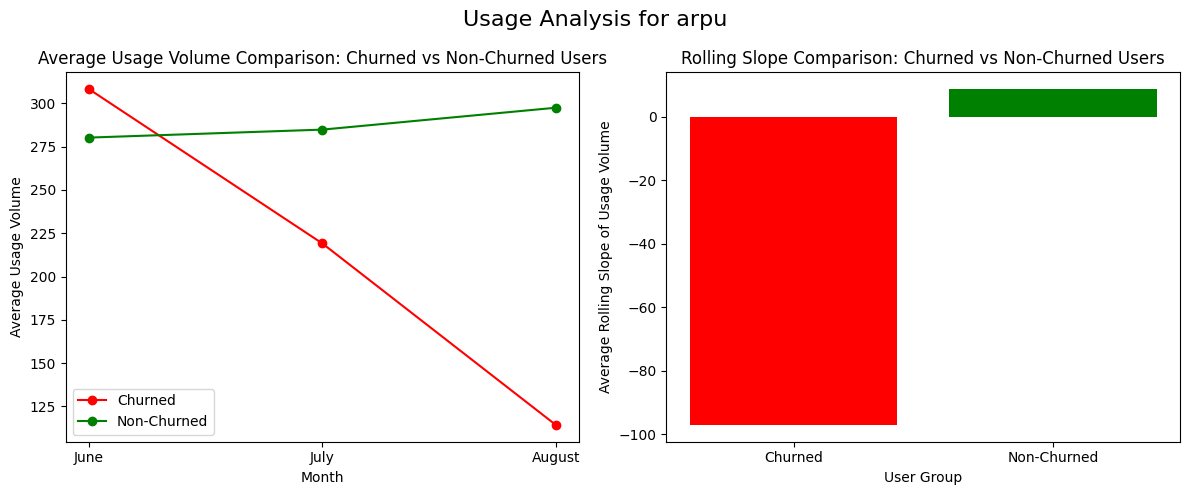

2. Slope_onnet_mou


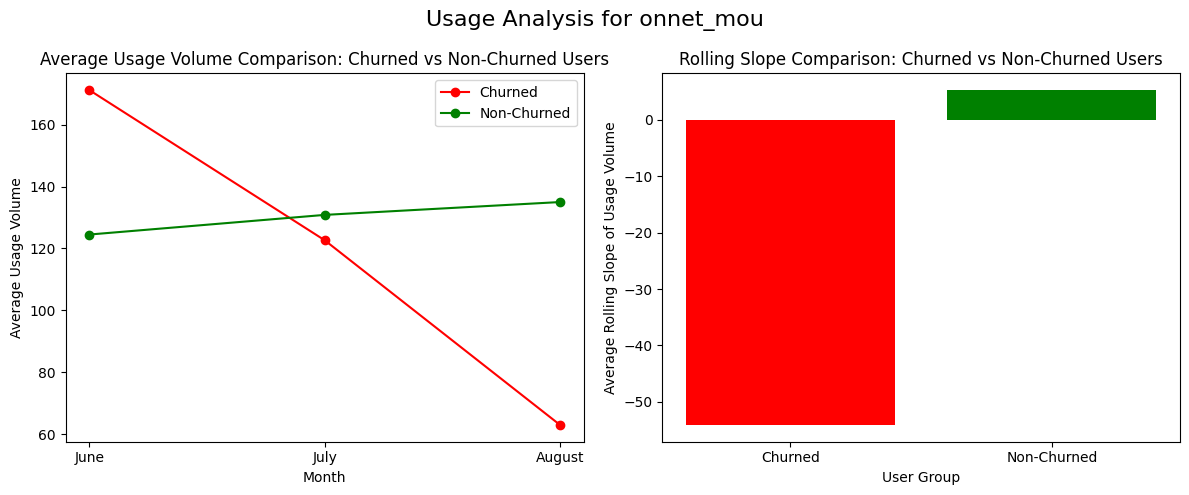

3. Slope_offnet_mou


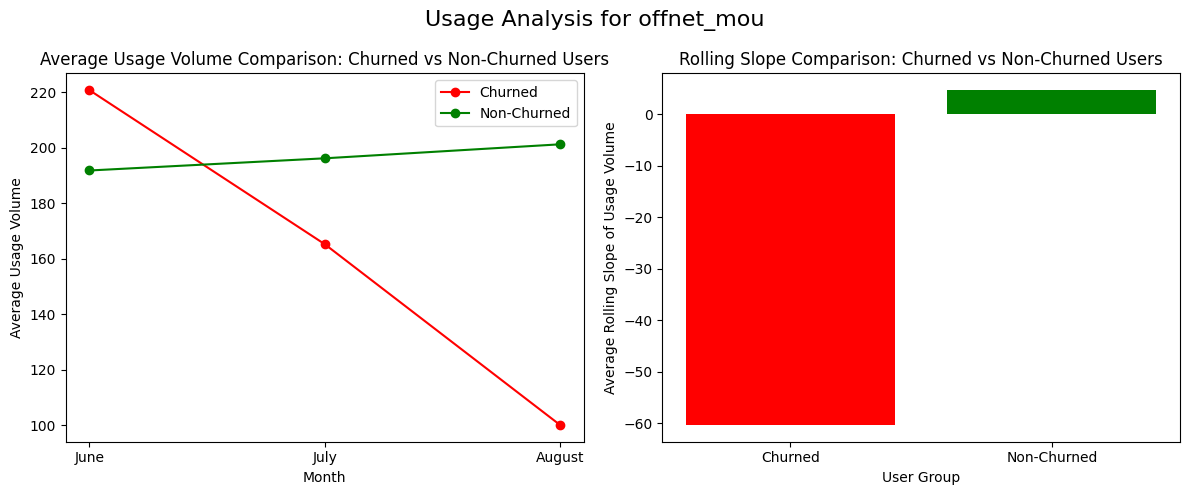

4. Slope_roam_ic_mou


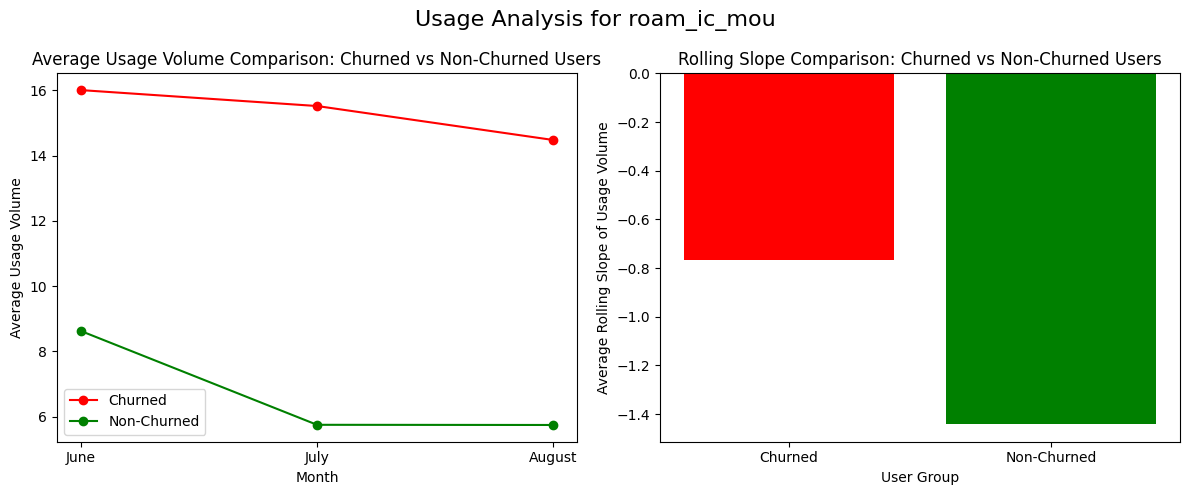

5. Slope_roam_og_mou


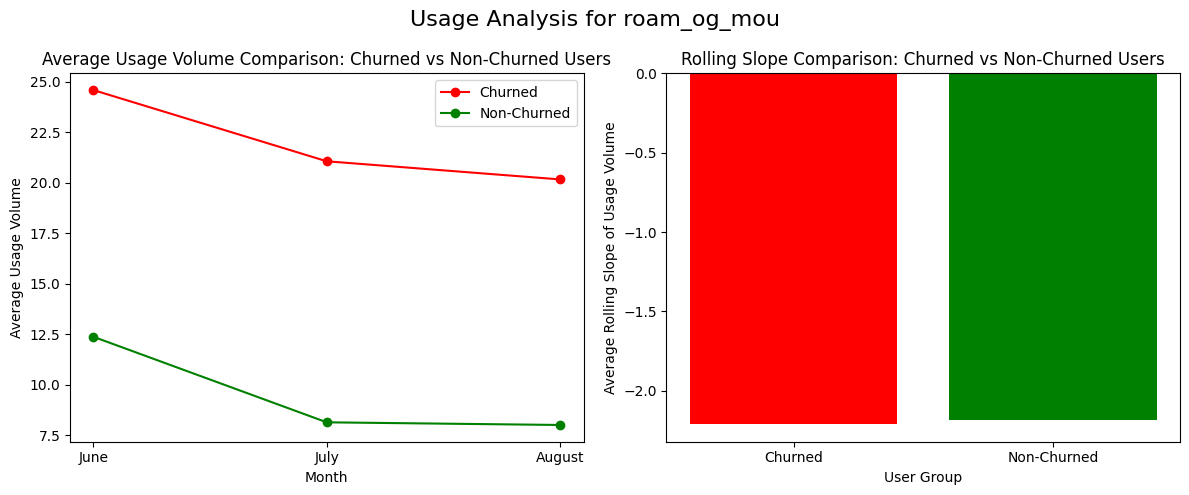

6. Slope_loc_og_t2t_mou


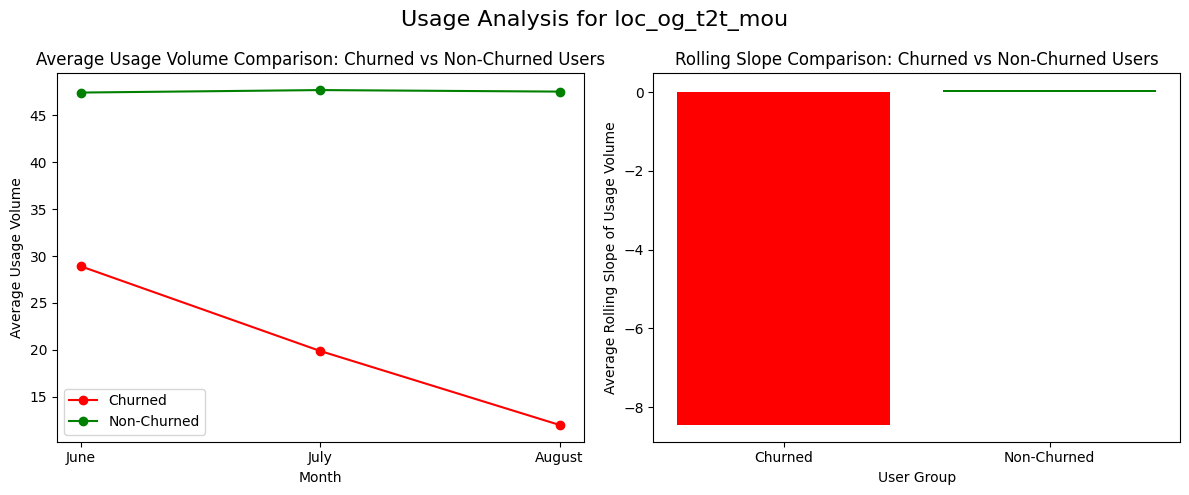

7. Slope_loc_og_t2m_mou


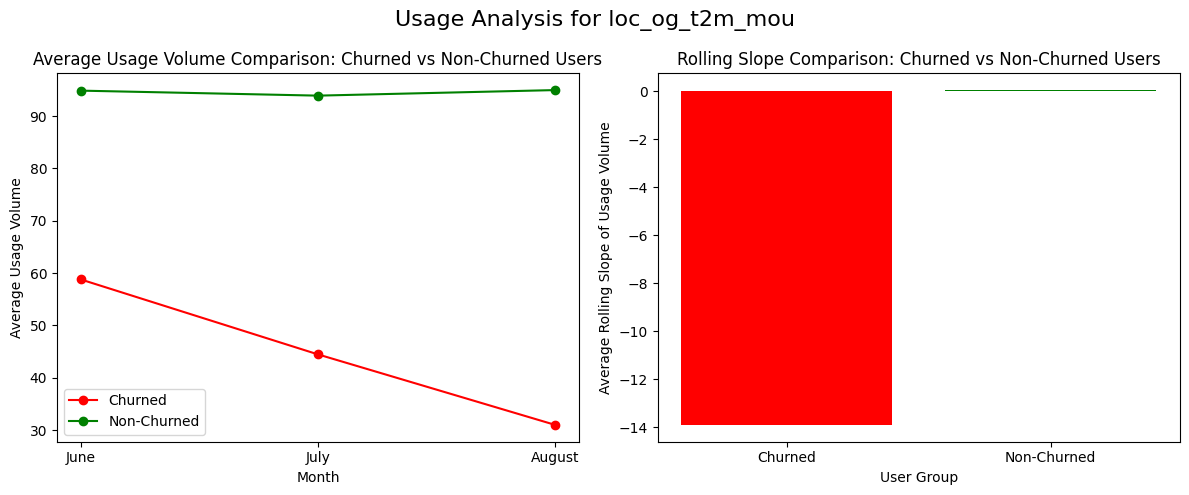

8. Slope_loc_og_t2f_mou


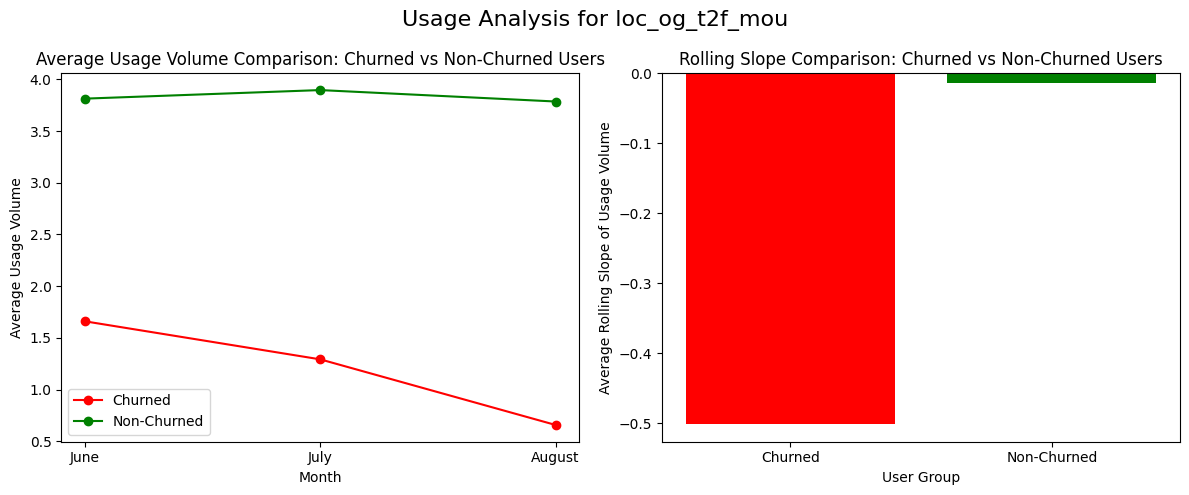

9. Slope_loc_og_t2c_mou


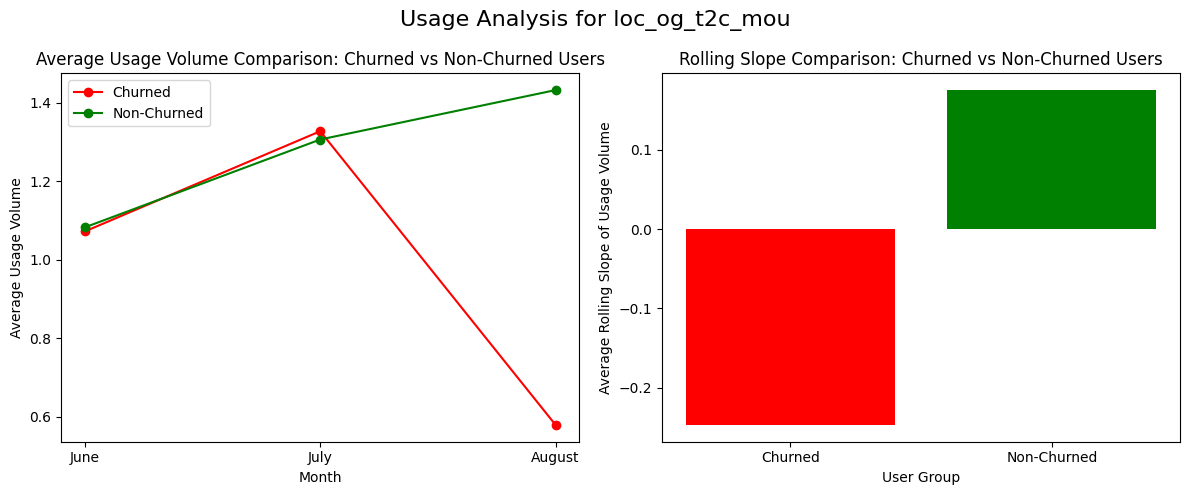

10. Slope_loc_og_mou


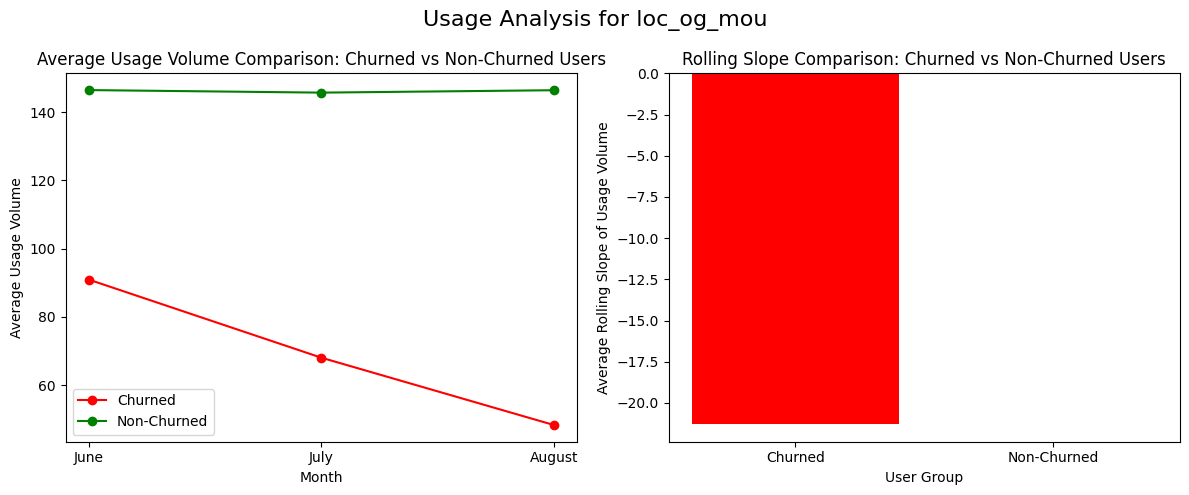

11. Slope_std_og_t2t_mou


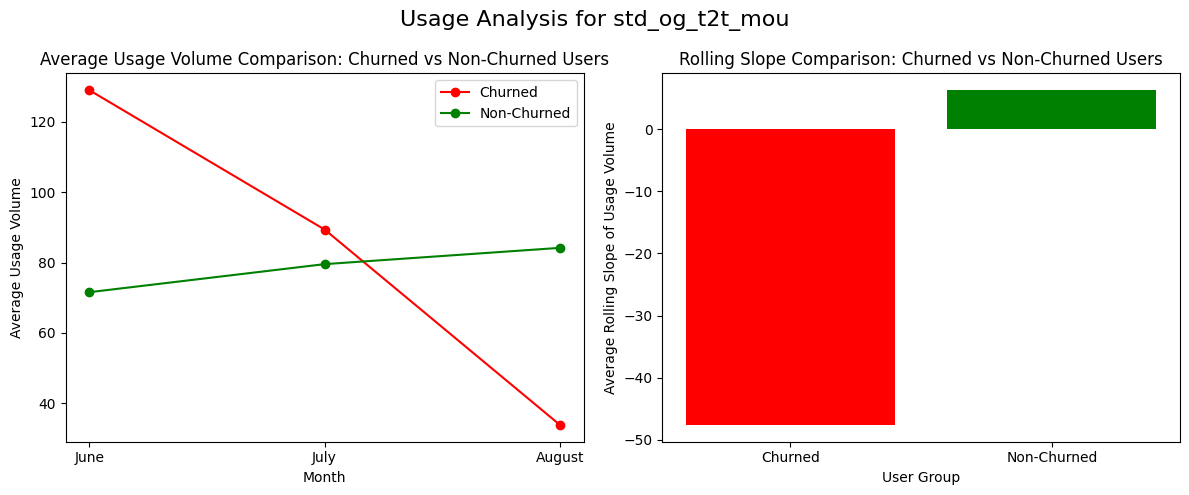

12. Slope_std_og_t2m_mou


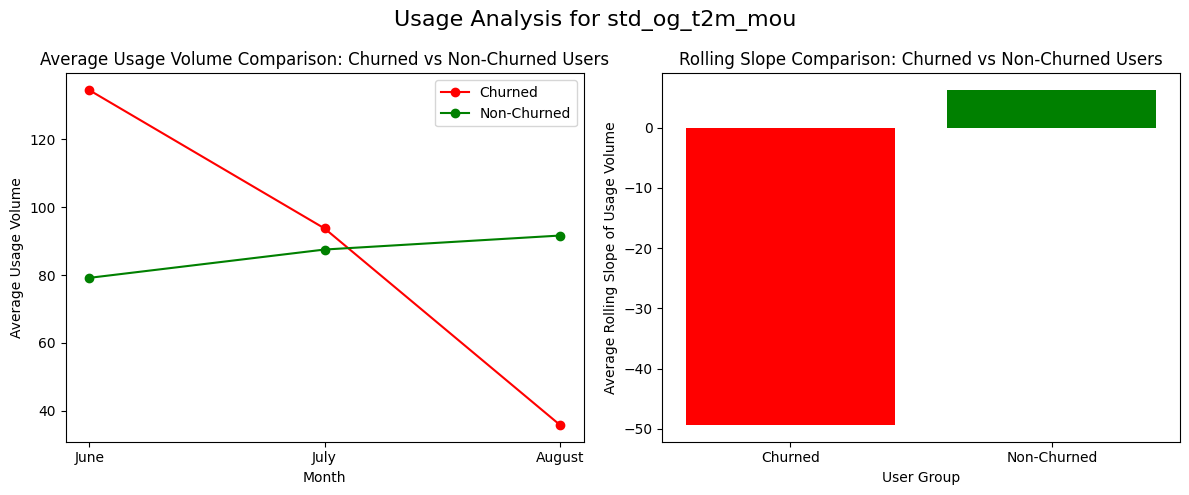

13. Slope_std_og_t2f_mou


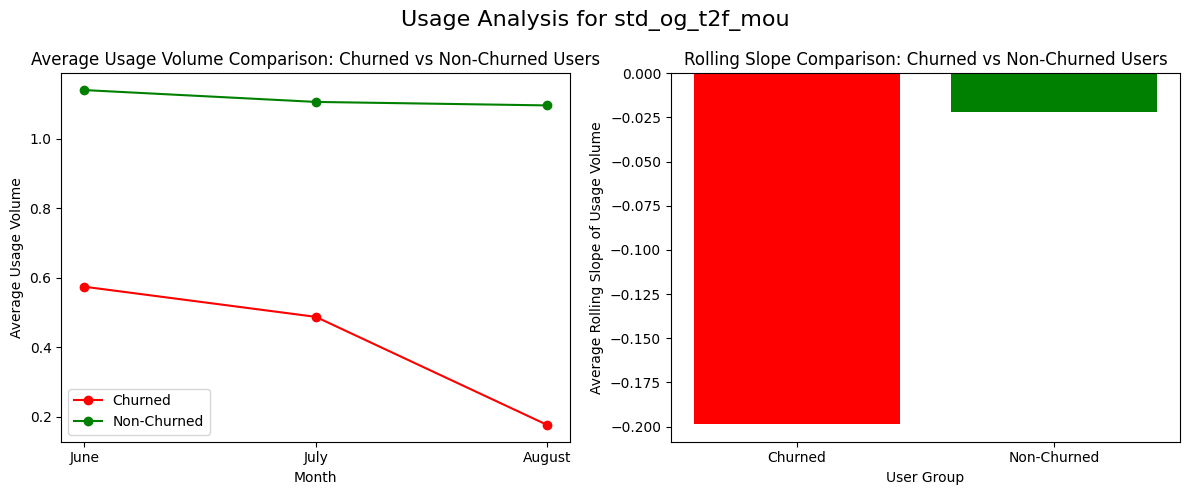

14. Slope_std_og_mou


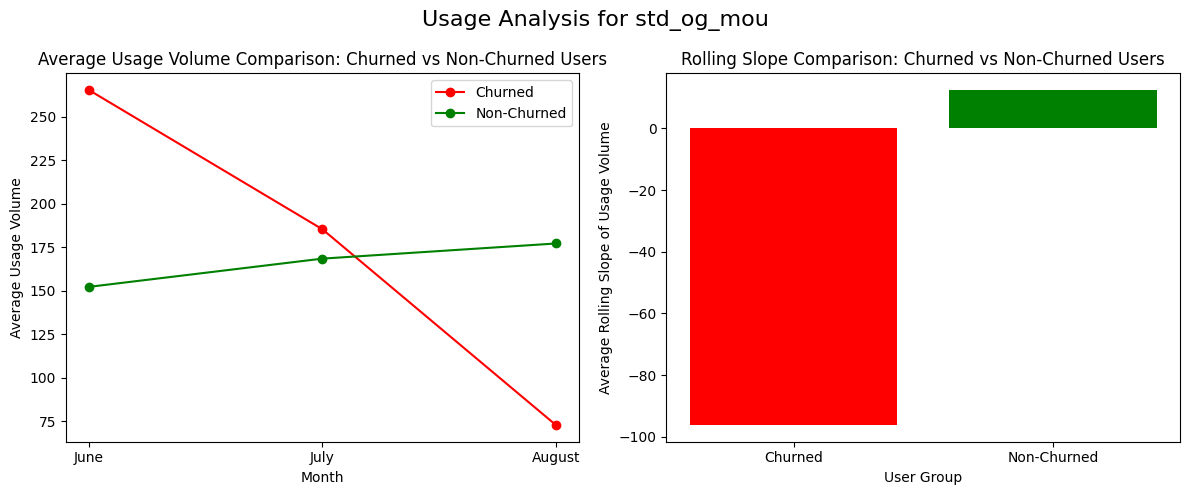

15. Slope_isd_og_mou


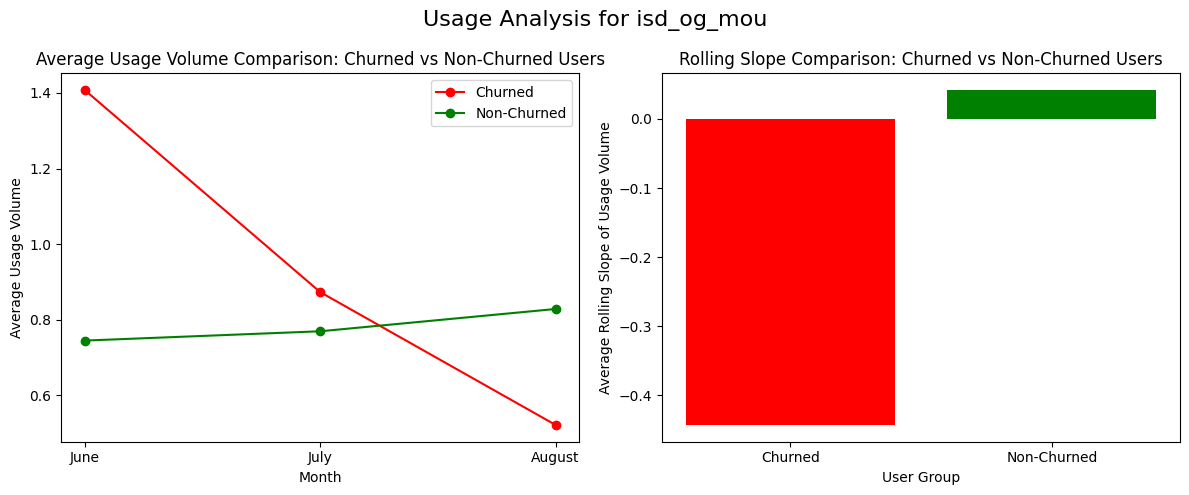

16. Slope_spl_og_mou


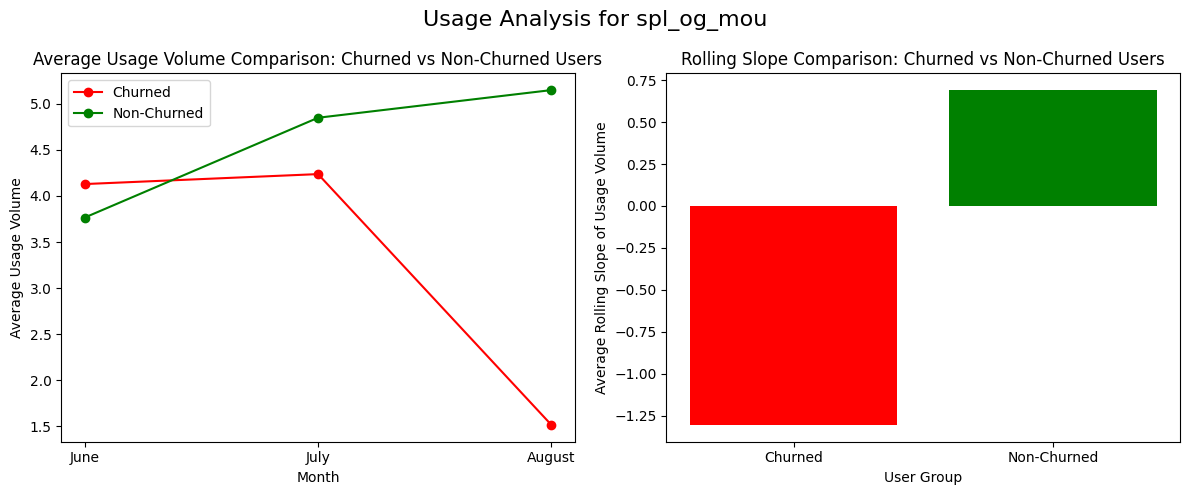

17. Slope_og_others


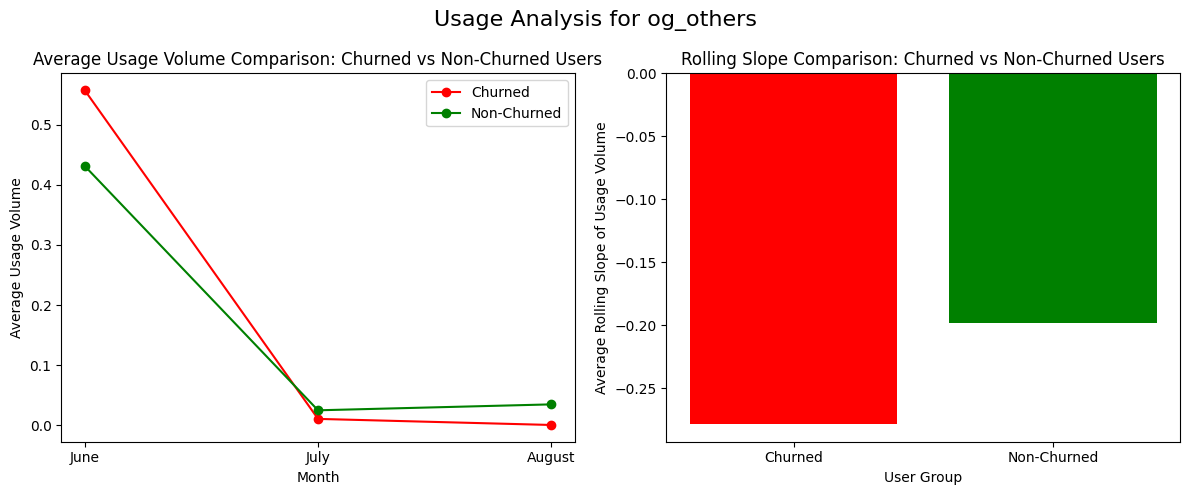

18. Slope_total_og_mou


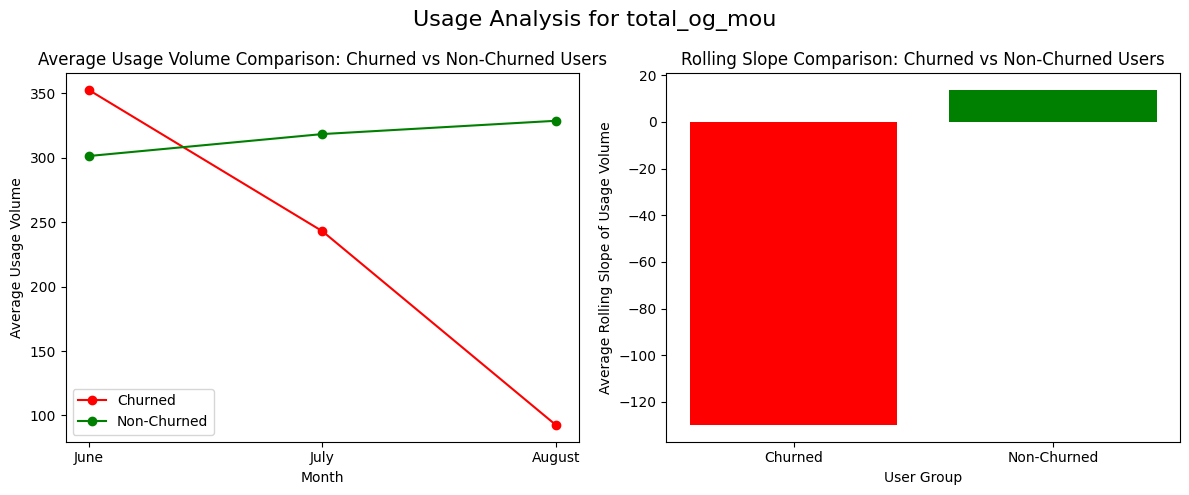

19. Slope_loc_ic_t2t_mou


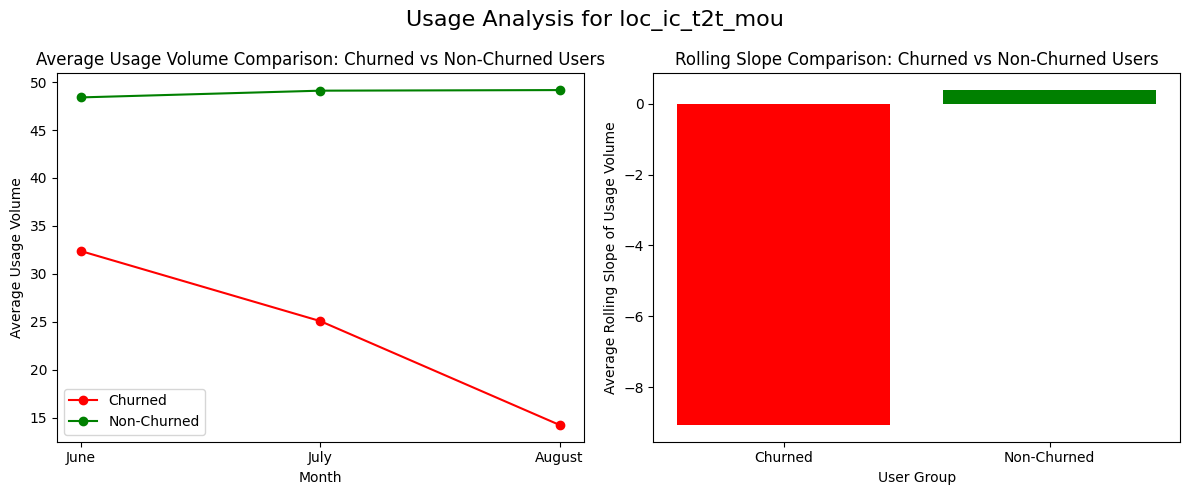

20. Slope_loc_ic_t2m_mou


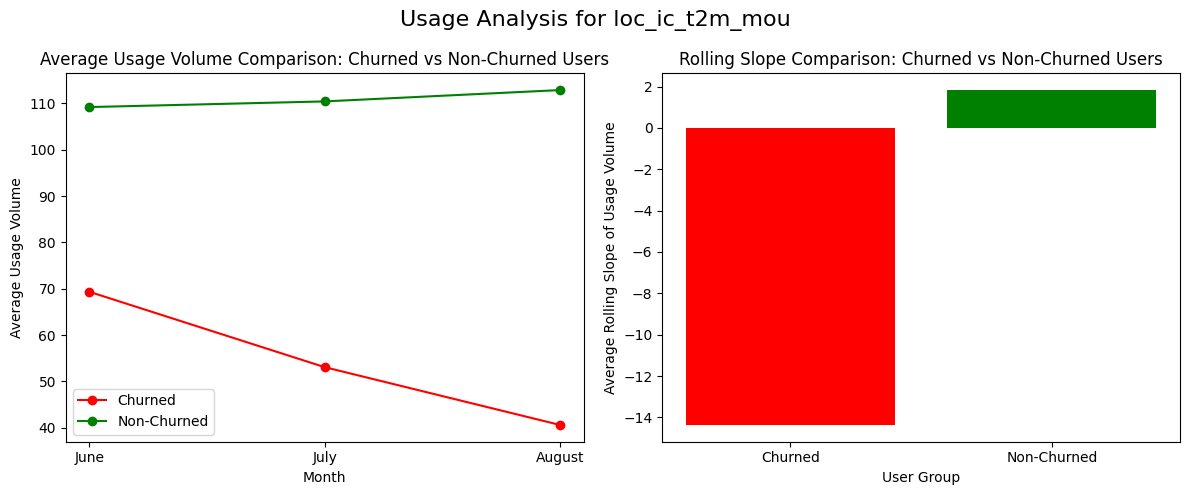

21. Slope_loc_ic_t2f_mou


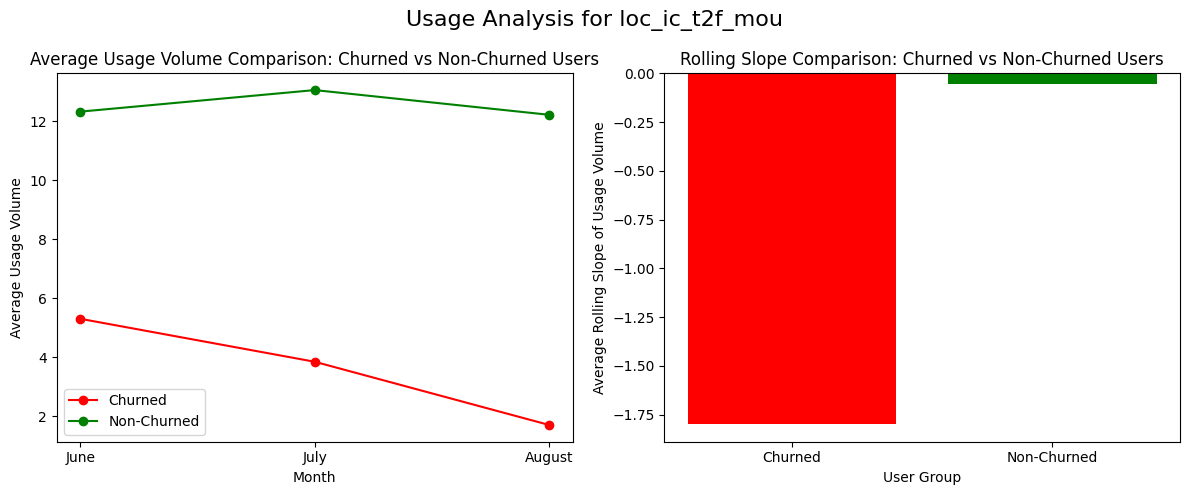

22. Slope_loc_ic_mou


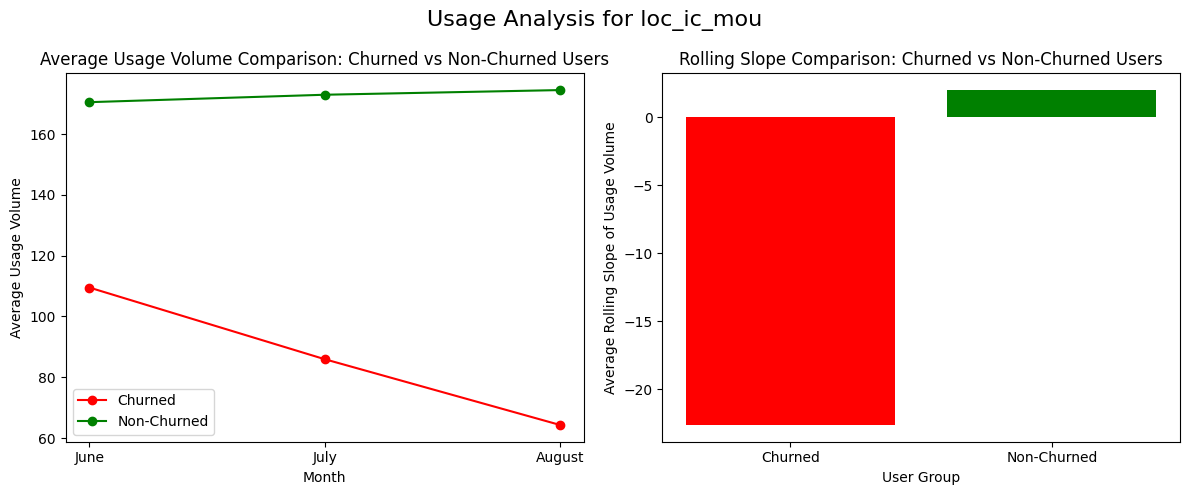

23. Slope_std_ic_t2t_mou


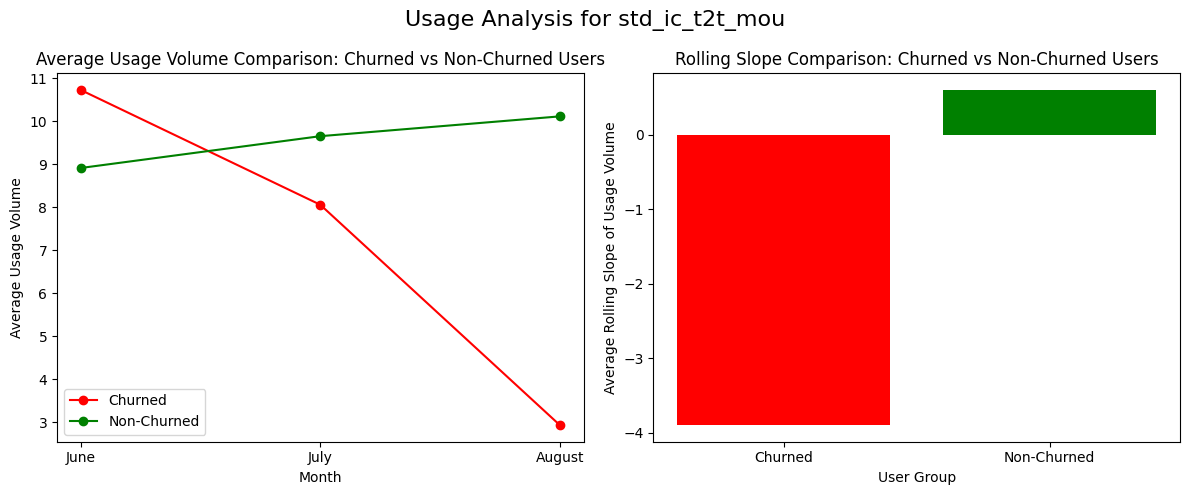

24. Slope_std_ic_t2m_mou


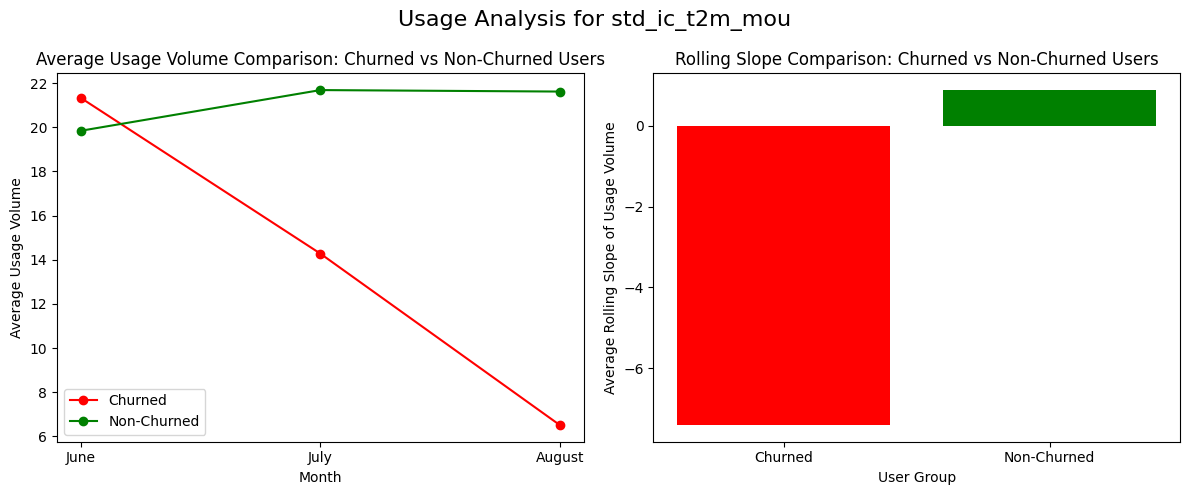

25. Slope_std_ic_t2f_mou


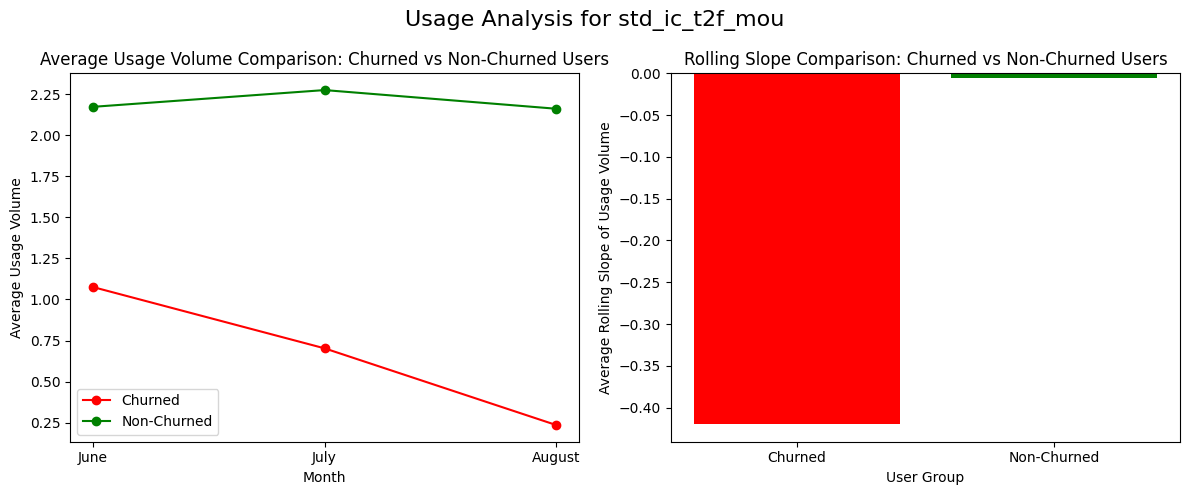

26. Slope_std_ic_mou


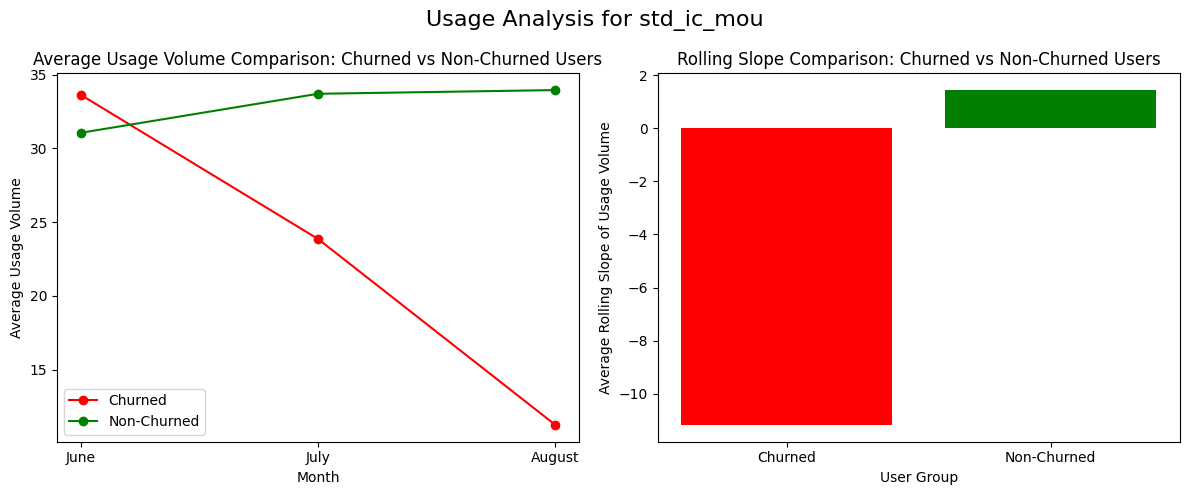

27. Slope_total_ic_mou


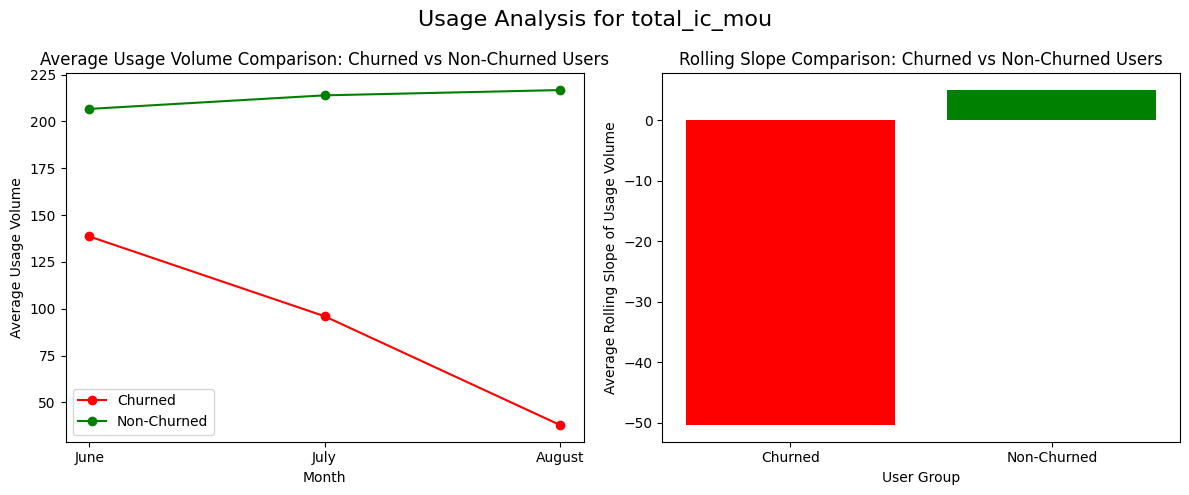

28. Slope_spl_ic_mou


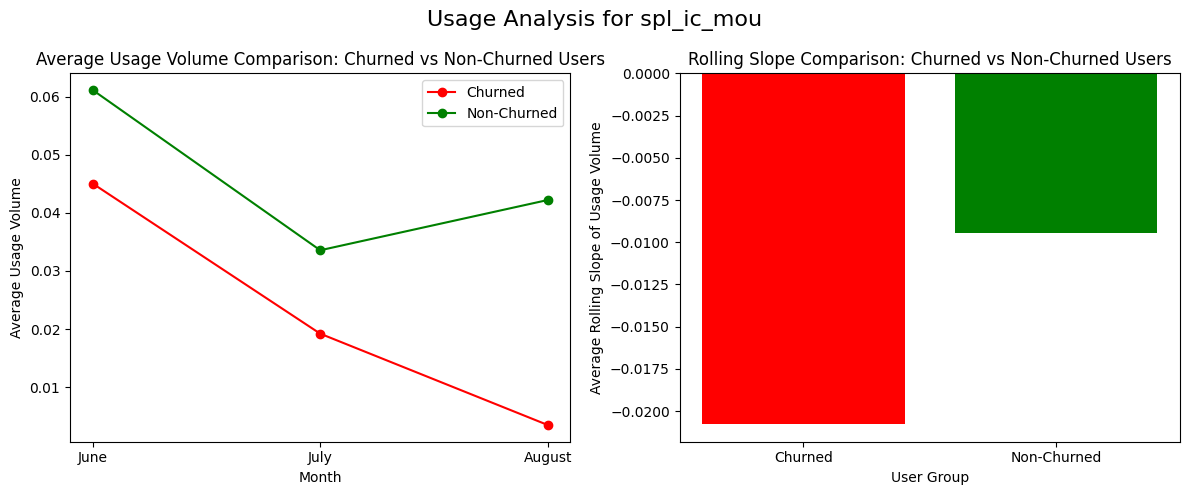

29. Slope_isd_ic_mou


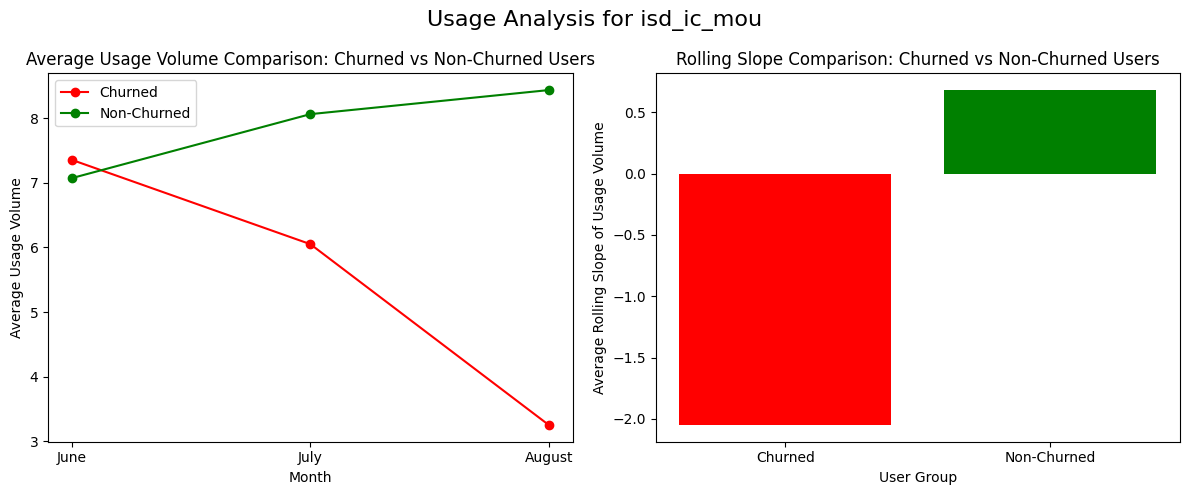

30. Slope_ic_others


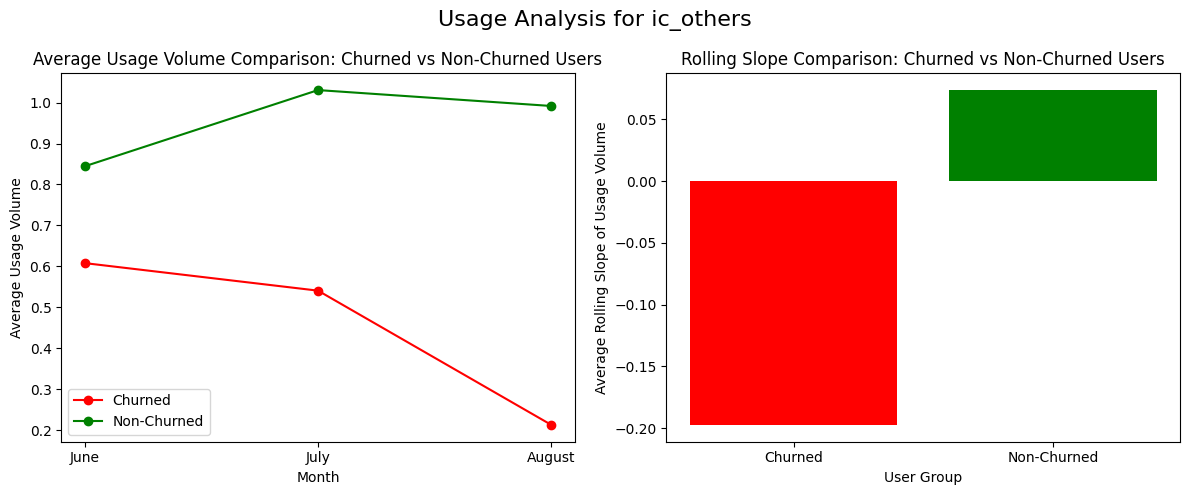

31. Slope_total_rech_num


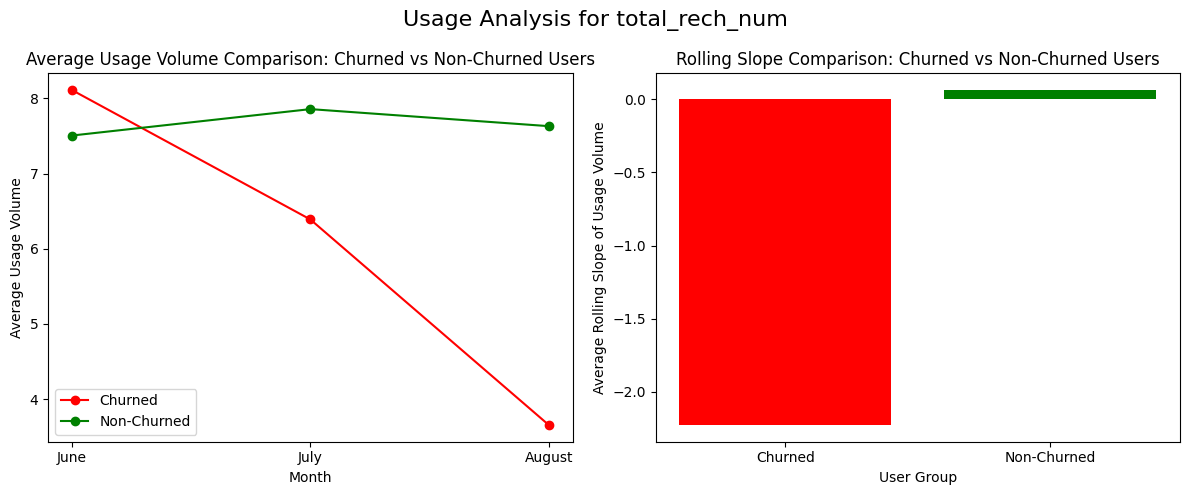

32. Slope_total_rech_amt


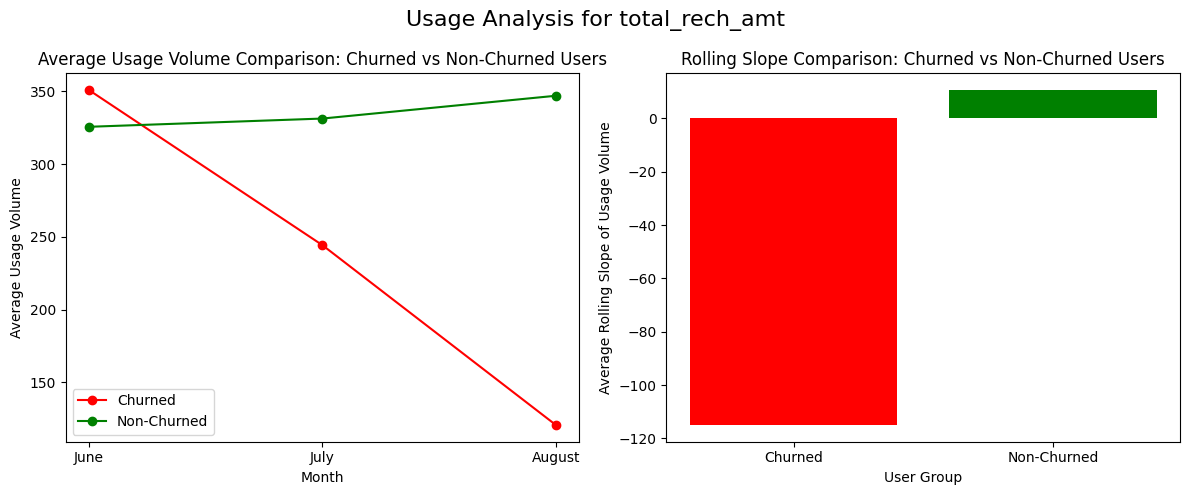

33. Slope_max_rech_amt


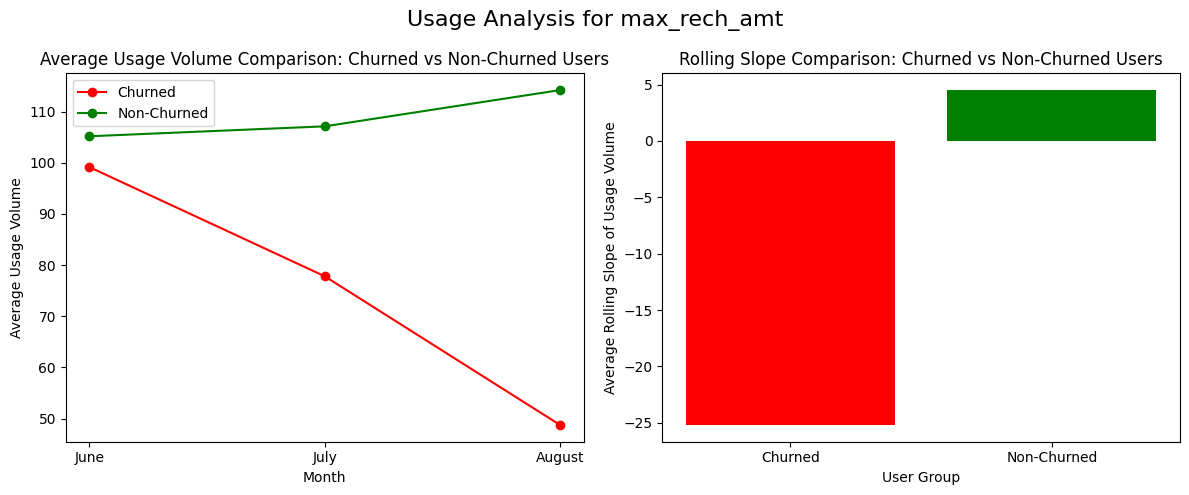

34. Slope_last_day_rch_amt


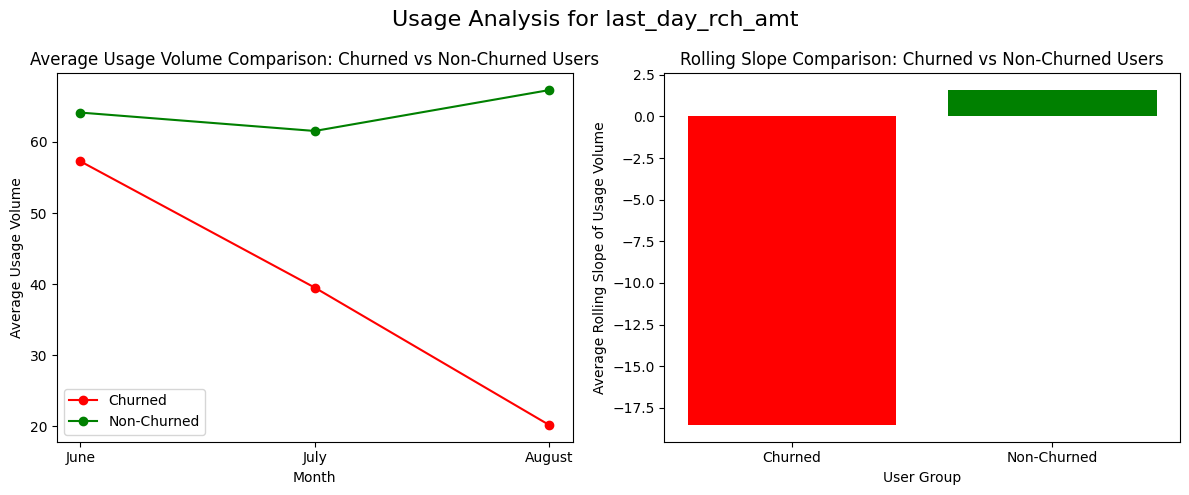

35. Slope_vol_2g_mb


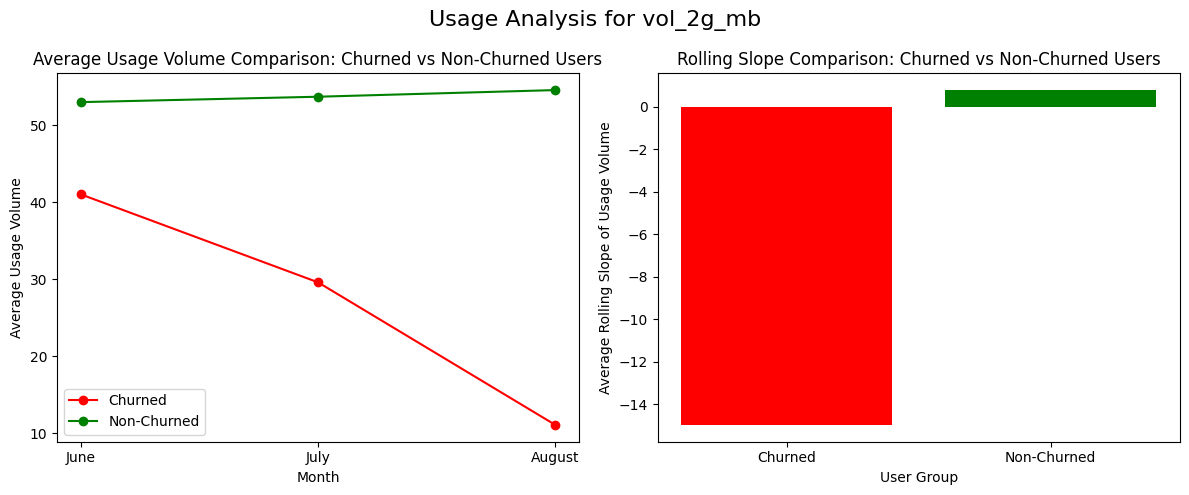

36. Slope_vol_3g_mb


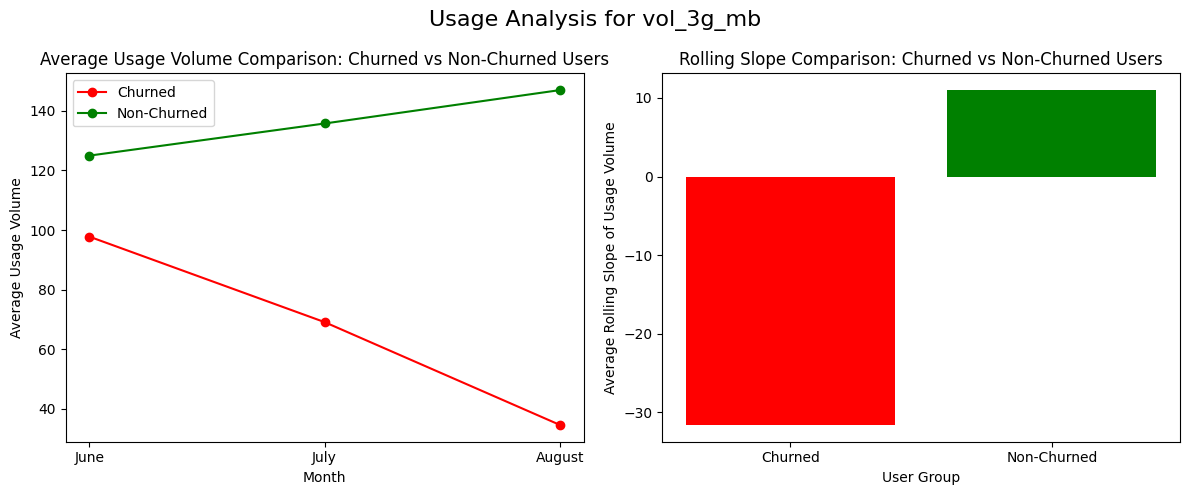

37. Slope_monthly_2g


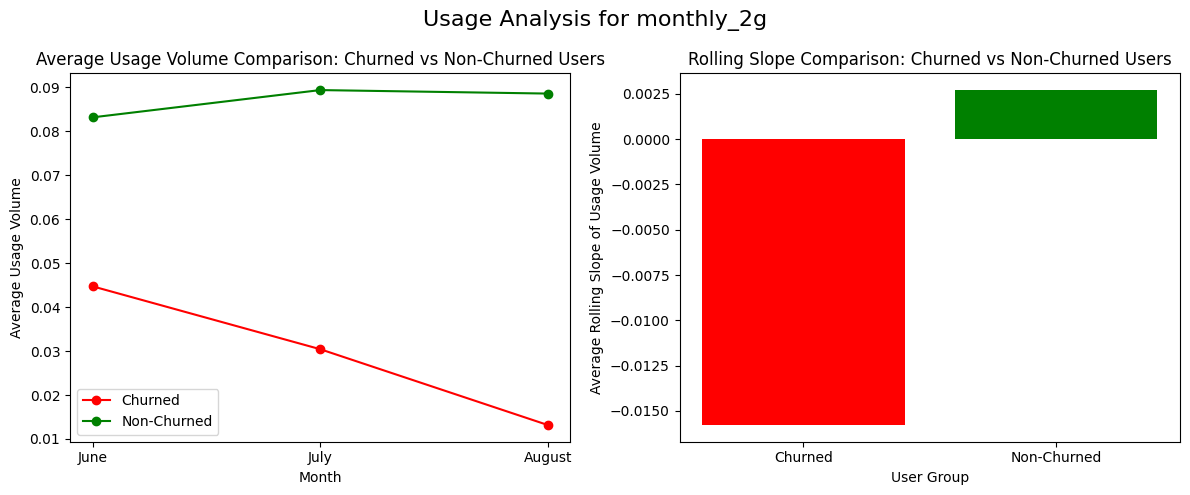

38. Slope_sachet_2g


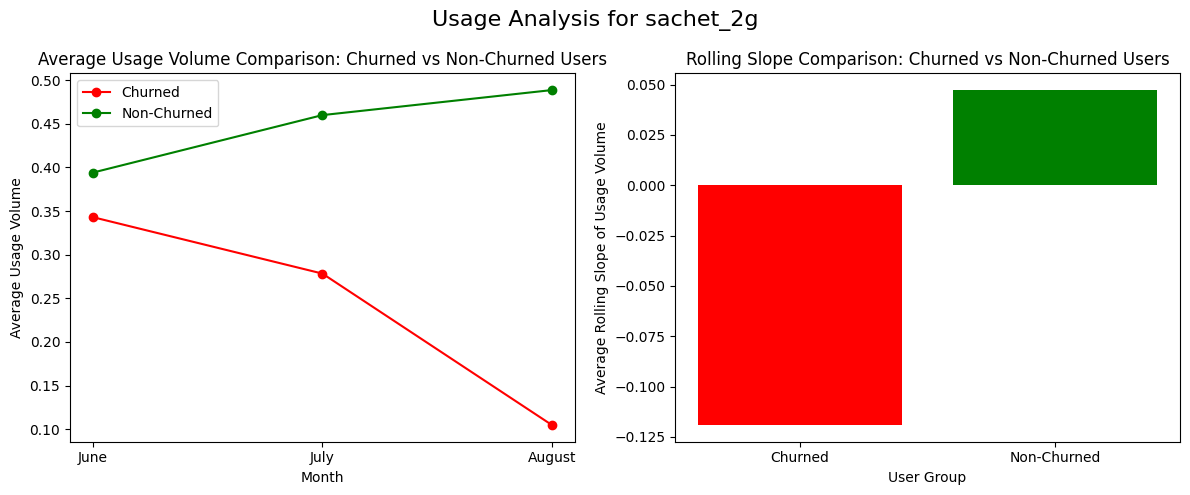

39. Slope_monthly_3g


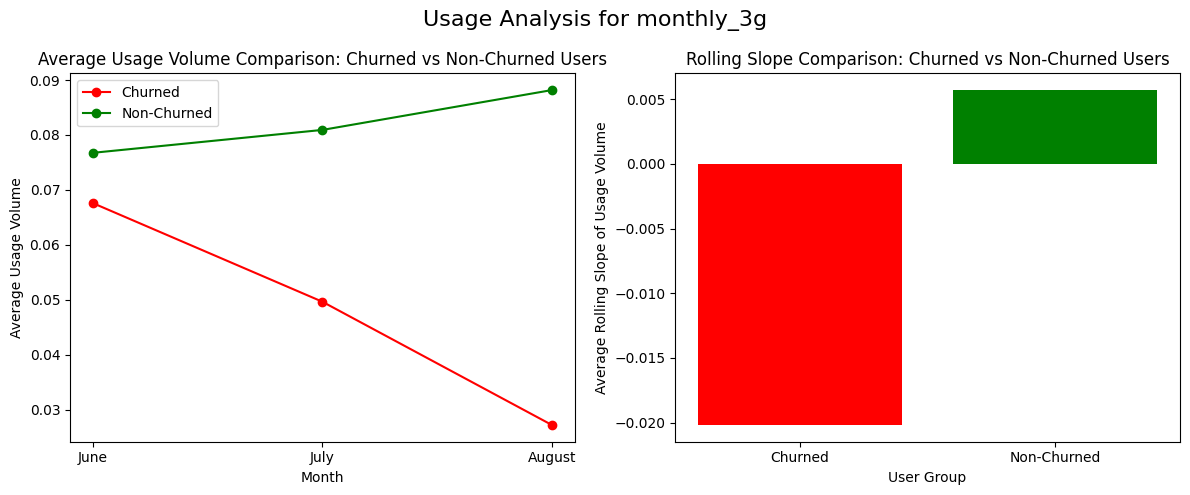

40. Slope_sachet_3g


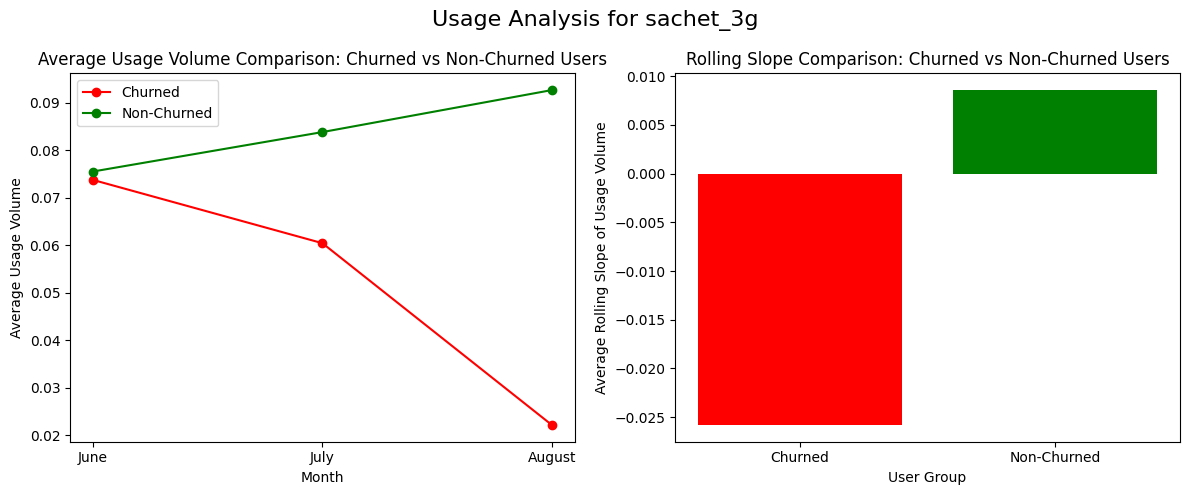

In [500]:
# Plot slope and monthly usage
for i, c in enumerate(column_groups, start=1):
    col_name = f'Slope_{c[0][:-2]}'
    print (f'{i}. {col_name}')
    # Plot slop and monthly average usages.
    plot_combined_metrics(
        data=data,
        col_june=c[0],
        col_july=c[1],
        col_aug=c[2],        
        slope=temp_data[col_name]
    )

### Outcome from review of slope and mothly usages trend plots
As expected, all variables show a declining trend in usage across all services and spending. In some cases, the decline is sharp, and in others, not as sharp, but it declines regardless.

We do not need original features. Let's drop original features and add slope of each KPI to main data.

In [501]:
columns_to_drop = [item for tup in column_groups for item in tup] # Columns to drop
# data = data.drop(columns=columns_to_drop)
data = pd.concat([data, temp_data], axis=1)

Let's build same slop variables and drop unwanted in unseen/test data as well.

In [502]:
temp_data = pd.DataFrame() # Empty dataframe 
for c in column_groups:
    # Calculate slop for unseen 
    slope, col_name = change_in_usages(
        data=unseen,
        col_june=c[0],
        col_july=c[1],
        col_aug=c[2]
    )
    temp_data[col_name] = slope

columns_to_drop = [item for tup in column_groups for item in tup] # Columns to drop
# unseen = unseen.drop(columns=columns_to_drop)
unseen = pd.concat([unseen, temp_data], axis=1)

Quick check on data shape to be sure we are golden.

In [503]:
data.shape, unseen.shape

((69999, 168), (30000, 167))

### Further EDA of remaining variables.

Let's review days since last recharge and data recharge.   

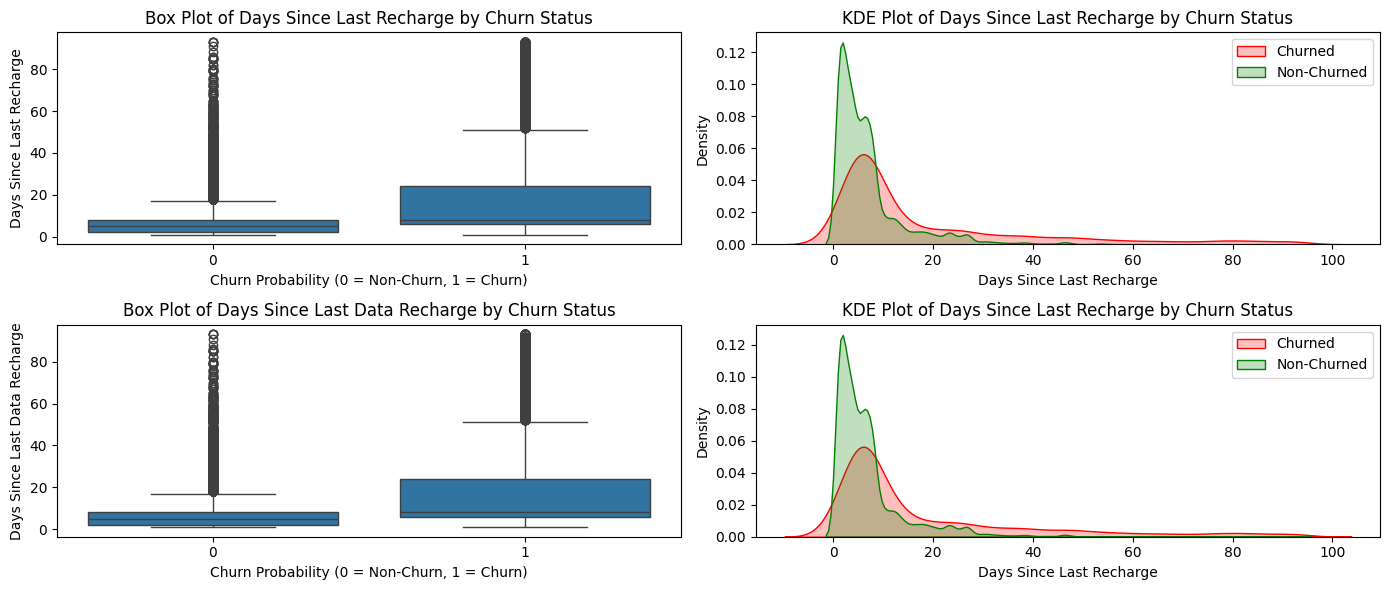

In [504]:
churned = data[data['churn_probability'] == 1]
non_churned = data[data['churn_probability'] == 0]

plt.figure(figsize=(14, 6))
# Box Plot
plt.subplot(2, 2, 1)
sns.boxplot(x='churn_probability', y='days_since_last_rech', data=data)
plt.xlabel('Churn Probability (0 = Non-Churn, 1 = Churn)')
plt.ylabel('Days Since Last Recharge')
plt.title('Box Plot of Days Since Last Recharge by Churn Status')
# Histogram/KDE Plot
plt.subplot(2, 2, 2)
sns.kdeplot(churned['days_since_last_rech'], label='Churned', fill=True, color='red')
sns.kdeplot(non_churned['days_since_last_rech'], label='Non-Churned', fill=True, color='green')
plt.xlabel('Days Since Last Recharge')
plt.ylabel('Density')
plt.title('KDE Plot of Days Since Last Recharge by Churn Status')
plt.legend()
# Show it
# plt.tight_layout()
# plt.show()


# plt.figure(figsize=(12, 5))
# Box Plot
plt.subplot(2, 2, 3)
sns.boxplot(x='churn_probability', y='days_since_last_rech_data', data=data)
plt.xlabel('Churn Probability (0 = Non-Churn, 1 = Churn)')
plt.ylabel('Days Since Last Data Recharge')
plt.title('Box Plot of Days Since Last Data Recharge by Churn Status')
# Histogram/KDE Plot
plt.subplot(2, 2, 4)
sns.kdeplot(churned['days_since_last_rech_data'], label='Churned', fill=True, color='red')
sns.kdeplot(non_churned['days_since_last_rech_data'], label='Non-Churned', fill=True, color='green')
plt.xlabel('Days Since Last Recharge')
plt.ylabel('Density')
plt.title('KDE Plot of Days Since Last Recharge by Churn Status')
plt.legend()
# Show it
plt.tight_layout()
plt.show()

Looks like less recharges closer to churn date. But not striong enough to say users don't recharge.

### Corr heatmap

In [507]:
data.shape

(69999, 168)

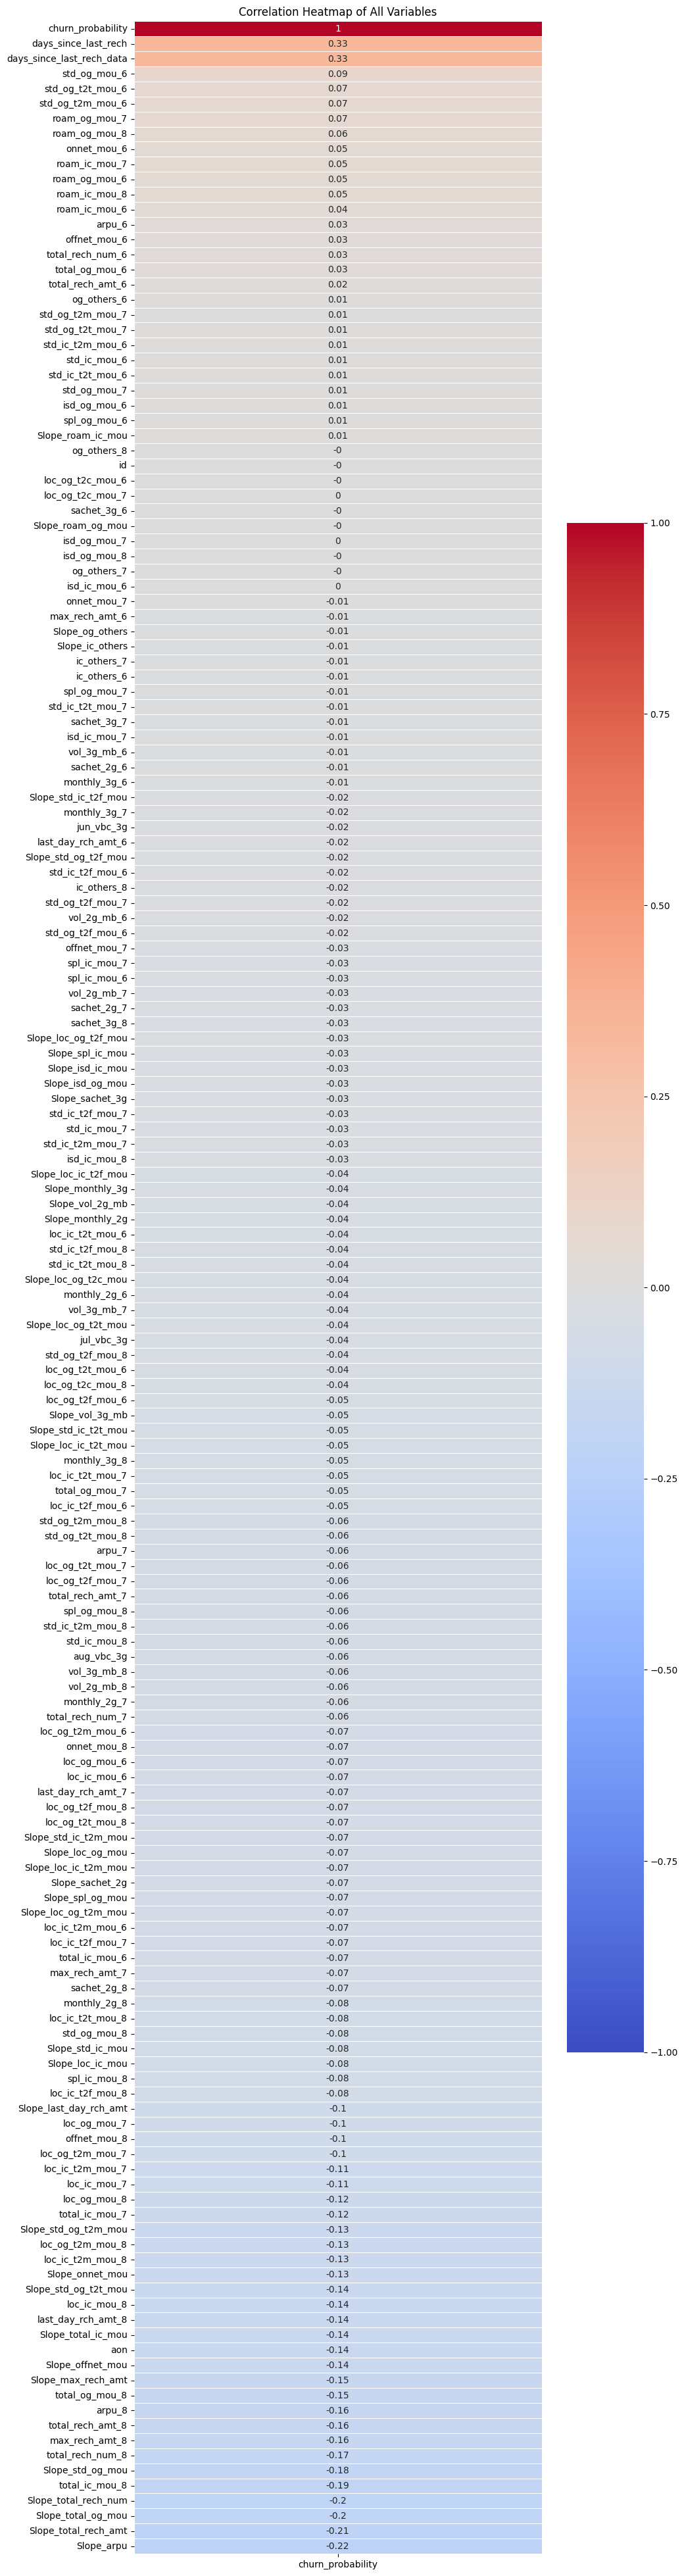

In [510]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create correlation matrix
correlation_matrix = data.corr().round(2).sort_values(by='churn_probability', ascending=False)

# Set up the matplotlib figure
plt.figure(figsize=(10, 50))

# Draw the heatmap focusing on correlations with churn_probability
correlation_matrix = correlation_matrix[['churn_probability']]
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

# Show the plot
plt.title('Correlation Heatmap of All Variables')
plt.show()

# XGBoost

In [443]:
features_to_drop = [
    "Slope_std_og_t2f_mou",
    "Slope_loc_ic_t2f_mou",
    "Slope_roam_ic_mou",
    "Slope_loc_og_t2c_mou",
    "jul_vbc_3g",
    "Slope_std_ic_t2f_mou",
    "Slope_isd_og_mou",
    "Slope_og_others",
    "Slope_ic_others",
    "Slope_total_rech_amt",
    "Slope_std_og_mou",
    "Slope_std_ic_t2t_mou",
    "Slope_loc_ic_t2t_mou",
    "Slope_loc_ic_t2m_mou",
    "days_since_last_rech_data",
    "Slope_std_ic_t2m_mou",
    "days_since_last_rech",
    "Slope_loc_og_mou",
    "Slope_std_ic_mou",
    "Slope_isd_ic_mou",
    "Slope_onnet_mou",
    "Slope_offnet_mou",
    "Slope_loc_ic_mou",
    "Slope_monthly_3g",
    "Slope_loc_og_t2f_mou",
    "Slope_roam_og_mou",
    "Slope_loc_og_t2t_mou",
    "Slope_std_og_t2t_mou",
    "Slope_loc_og_t2m_mou",
    "Slope_std_og_t2m_mou"
]


In [444]:
# Prepare data for modeling
X = data.drop(columns=['id', 'churn_probability'])
X = X.drop(columns=features_to_drop)
y = data['churn_probability']

# Scale the data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Prepare unseen data aswell
unseen_copy = unseen.copy()

In [445]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the training data
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
# Train an XGBoost classifier to see if this feature can explain churn
xgb_model = XGBClassifier(
    booster='gblinear',
    # scale_pos_weight = sum(y_train == 0) / sum(y_train == 1),
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42)
xgb_model.fit(X_train, y_train)

In [447]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1] # Probabilities for the churn class (churn_probability=1)

In [448]:
# # Let's find the best possible threhold
# thresholds = np.linspace(0, 1, 100)
# best_threshold = 0.5
# best_f1 = 0

# for threshold in thresholds:
#     # Convert probabilities to binary predictions based on the threshold
#     y_pred_threshold = (y_pred_prob >= threshold).astype(int)

#     # Calculate recall, precision, and F1 score
#     recall = recall_score(y_test, y_pred_threshold)
#     precision = precision_score(y_test, y_pred_threshold, zero_division=False)
#     f1 = f1_score(y_test, y_pred_threshold)

#     # Track the best threshold based on F1 score (or other metric)
#     if f1 > best_f1:
#         best_f1 = f1
#         best_threshold = threshold

# print(f"Best threshold: {best_threshold}, Best F1 Score: {best_f1}")

In [449]:
# Predication
# y_pred = (y_pred_prob >= best_threshold).astype(int)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Calculate F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Precision, Recall, and F1 Score vs Threshold')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model : {accuracy:.2f}\n")

In [ ]:
# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.2f}\n")

In [ ]:
# Plotting the classification report using seaborn
print(
    'Classification report :\n',
    classification_report(y_test, y_pred, digits=2, zero_division=False))

In [ ]:
# Plot ROC Curve and Confusion Matrix side by side
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Plot ROC Curve
ax[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax[0].plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[0].legend(loc='lower right')
ax[0].grid()
# Plot Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax[1])
ax[1].set_xlabel('Predicted Label')
ax[1].set_ylabel('True Label')
ax[1].set_title('Confusion Matrix')
# Show the plot
plt.tight_layout()
plt.show()

In [455]:
# Important features
features_importance = pd.DataFrame({"features" : X_train.columns, "importance" : xgb_model.feature_importances_})
features_importance.to_csv('XGBoost_importance.csv')

In [456]:
xgb_predictions = xgb_model.predict(unseen_copy[X.columns])
submission_xgb = pd.DataFrame({'id': unseen_copy['id'].astype(int), 'churn_probability': xgb_predictions})
submission_xgb_file_name = f"xgb_churn_prediction_{datetime.now().strftime('%Y%m%d')}.csv"
submission_xgb.to_csv(submission_xgb_file_name, index=False)